## Train for Baseline Model (End - to - End)
### Load H5 file & Explore

In [9]:
# import required packages

import numpy as np  ## 1.24.4
import torch  ## 2.4.1
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt  ## 3.7.5
import os
import h5py  ## 3.11.0
from scipy.spatial.transform import Rotation as R  ## 3.11.0
import pickle
from sklearn.preprocessing import StandardScaler  ## 1.3.2
import re

In [ ]:
# ##### == In case of Trash Data has been found == #####

# file_path = os.path.expanduser("~/mpac_go2/build/data/20250321/143506_a1.h5")  # Latest data

# with h5py.File(file_path, 'r+') as f:
#     # data = np.array( f["common_timeseries"][:]['q'] )
#     data = f["common_timeseries"]
#     full_data = data[:]S
#     # print(data.shape)

#     print("Before: ")
#     print(full_data[96919]['q'][0:2])
#     print(full_data[514470]['q'][0:2])

#     full_data[96919]['q'][0:2] = full_data[96919 + 1]['q'][0:2]
#     full_data[514470]['q'][0:2] = full_data[514470 + 1]['q'][0:2]

#     print("After: ")
#     print(full_data[96919]['q'][0:2])
#     print(full_data[514470]['q'][0:2])

#     del f["common_timeseries"]
#     f.create_dataset( "common_timeseries", data=full_data)


# print("\nRead again")
# # Read again
# with h5py.File(file_path, 'r') as f:
#     # data = np.array( f["common_timeseries"][:]['q'] )
#     data = f["common_timeseries"][:]['q']
#     # print(data.shape)

#     print("Before: ")
#     print(data[96919, 0:2])
#     print(data[514470, 0:2])

In [2]:
def explore_h5_file(file_path):
    with h5py.File(file_path, 'r') as h5_file:
        def print_structure(name, obj):
            if isinstance(obj, h5py.Group):
                print(f"Group: {name}")
            elif isinstance(obj, h5py.Dataset):
                print(f"Dataset: {name}, Shape: {obj.shape}, Dtype: {obj.dtype}")

        print("HDF5 File Structure:")
        h5_file.visititems(print_structure)

# file_path = os.path.expanduser("~/mpac_go2/build/data/latest.h5")  # Latest data

# file_path = os.path.expanduser("~/mpac_go2/build/data/20250321/143506_a1.h5")  # Training1
file_path = os.path.expanduser("~/mpac_go2/build/data/20250326/154150_a1.h5")  # Training2
explore_h5_file(file_path)

HDF5 File Structure:
Dataset: bound_attributes, Shape: (0,), Dtype: |S1
Dataset: bound_timeseries, Shape: (0,), Dtype: |S1
Dataset: calibrate_attributes, Shape: (0,), Dtype: |S1
Dataset: calibrate_timeseries, Shape: (0,), Dtype: |S1
Dataset: common_attributes, Shape: (1,), Dtype: {'names': ['epoch_time', 'cycle_duration', 'compute_duration', 'tictoc', 'path_compute_duration', 'q', 'qd', 'u', 'act_mode', 'q_des', 'qd_des', 'u_des', 'f', 'temp'], 'formats': [[('name', 'S32'), ('units', 'S32'), ('crit_lo', '<f8'), ('warn_lo', '<f8'), ('warn_hi', '<f8'), ('crit_hi', '<f8')], [('name', 'S32'), ('units', 'S32'), ('crit_lo', '<f8'), ('warn_lo', '<f8'), ('warn_hi', '<f8'), ('crit_hi', '<f8')], [('name', 'S32'), ('units', 'S32'), ('crit_lo', '<f8'), ('warn_lo', '<f8'), ('warn_hi', '<f8'), ('crit_hi', '<f8')], [('name', 'S32'), ('units', 'S32'), ('crit_lo', '<f8'), ('warn_lo', '<f8'), ('warn_hi', '<f8'), ('crit_hi', '<f8')], [('name', 'S32'), ('units', 'S32'), ('crit_lo', '<f8'), ('warn_lo', '<f

### Extract desired data

In [34]:
with h5py.File(file_path, 'r') as f:
    dataset = np.array( f["common_timeseries"] )  # Data as numpy array

N_t = dataset.shape[0]  # Total timesteps
print( "Total number of timesteps of Dataset:" )
print( N_t )

print( "\nData type of Dataset:" )
print( dataset.dtype )  # Data types

# 1. Timestamps
time = dataset[:]['epoch_time']
time = np.round( time - time[0] , 4) # Shift - make starting time as 0

# 2. q
q = dataset[:]['q'] # Joint position variable
dim = q[0].shape[0] # Dimension of q
print("\nDimension of Variable (q):")
print(dim)
# Data meanings
"""
X_global: Global position of robot's body - X
Y_global: Global position of robot's body - Y
Z_global: Global position of robot's body - Z
Rx: Euler angle to express body posture - X
Ry: Euler angle to express body posture - Y
Rz: Euler angle to express body posture - Z
Q: Joint Positions - 12 dim. in total (3 for eag leg, 4 legs)
"""
q_name = np.array(["X_global", "Y_global", "Z_global", "Rx", "Ry", "Rz", "Q_FL1", "Q_FL2", "Q_FL3", "Q_FR1", "Q_FR2", "Q_FR3", "Q_RL1", "Q_RL2", "Q_RL3", "Q_RR1", "Q_RR2", "Q_RR3"])
qd_name = np.array(["X_global_dot", "Y_global_dot", "Z_global_dot", "Rx_dot", "Ry_dot", "Rz_dot", "Q_FL1_dot", "Q_FL2_dot", "Q_FL3_dot", "Q_FR1_dot", "Q_FR2_dot", "Q_FR3_dot", "Q_RL1_dot", "Q_RL2_dot", "Q_RL3_dot", "Q_RR1_dot", "Q_RR2_dot", "Q_RR3_dot"])


# 3. qd
qd = dataset[:]['qd'] # Joint velocity variable

# 4. v_cmd
ctrl_des = dataset[:]['ctrl_mode_des']
# Regular expression to capture numbers (including negative and decimal)
pattern = r'[-+]?\d*\.\d+|[-+]?\d+'
arguments = np.zeros( (N_t, 4) )
for i in range(N_t):
    try:
        numbers = [float(num) for num in re.findall(pattern, dataset[i]['ctrl_mode_des'].decode('utf-8'))]
        if len(numbers) == 0:  # When there are no arguments
            arguments[i, :] = np.zeros(4)
        else:
            arguments[i, :len(numbers)] = np.array(numbers)

    except Exception as e:
        print(f"Error at index {i}: {e}")
        arguments[i, :] = np.zeros(4)

# 5. tau_cmd

Total number of timesteps of Dataset:
286821

Data type of Dataset:
{'names': ['local_date', 'local_time', 'epoch_time', 'cycle_count', 'cycle_duration', 'compute_duration', 'tictoc', 'path_compute_duration', 'q', 'qd', 'u', 'temp', 'act_mode', 'q_des', 'qd_des', 'u_des', 'f', 'ctrl_mode_curr', 'ctrl_mode_next', 'ctrl_mode_des', 'prim_path', 'prim_tlm_index'], 'formats': ['S32', 'S32', '<f16', '<u8', '<f8', '<f8', '<f8', '<f8', ('<f8', (18,)), ('<f8', (18,)), ('<f8', (12,)), ('<f8', (12,)), ('<i4', (12,)), ('<f8', (12,)), ('<f8', (12,)), ('<f8', (12,)), ('<f8', (4,)), 'S128', 'S128', 'S128', ('S128', (8,)), '<u8'], 'offsets': [3280, 3312, 3264, 16, 24, 32, 40, 48, 56, 200, 488, 952, 584, 728, 824, 632, 920, 3344, 3472, 3600, 3728, 4752], 'itemsize': 4768}

Dimension of Variable (q):
18


### Explore

/tmp/ipykernel_461523/1018304832.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure( figsize=[24, 6] )


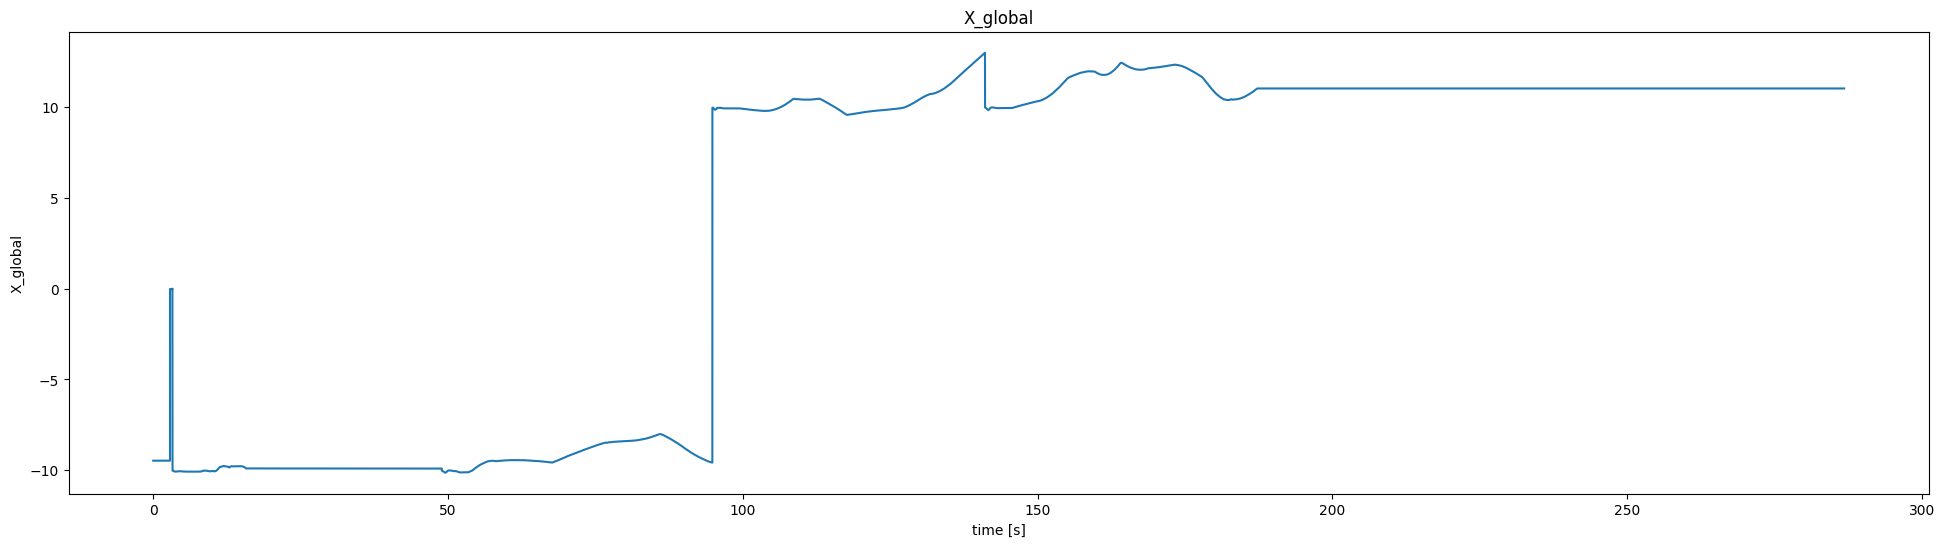

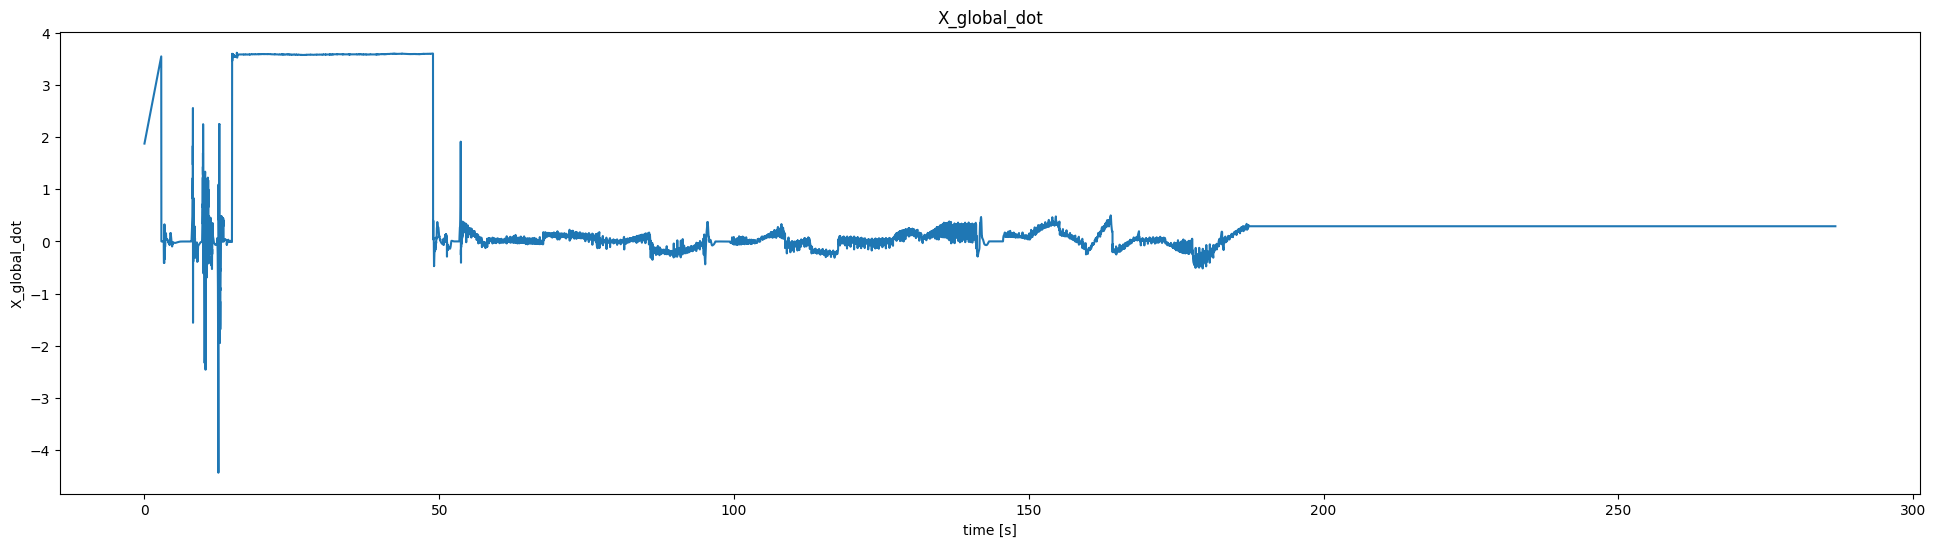

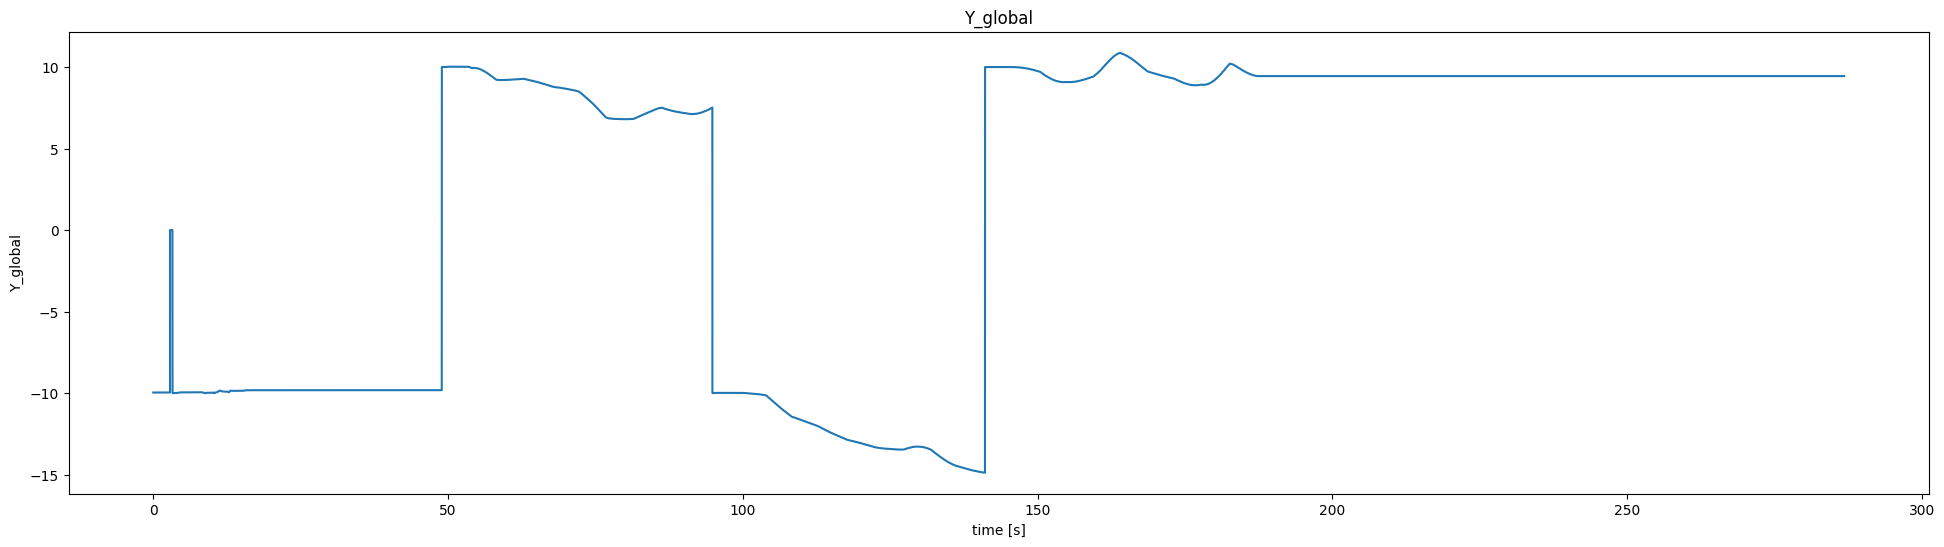

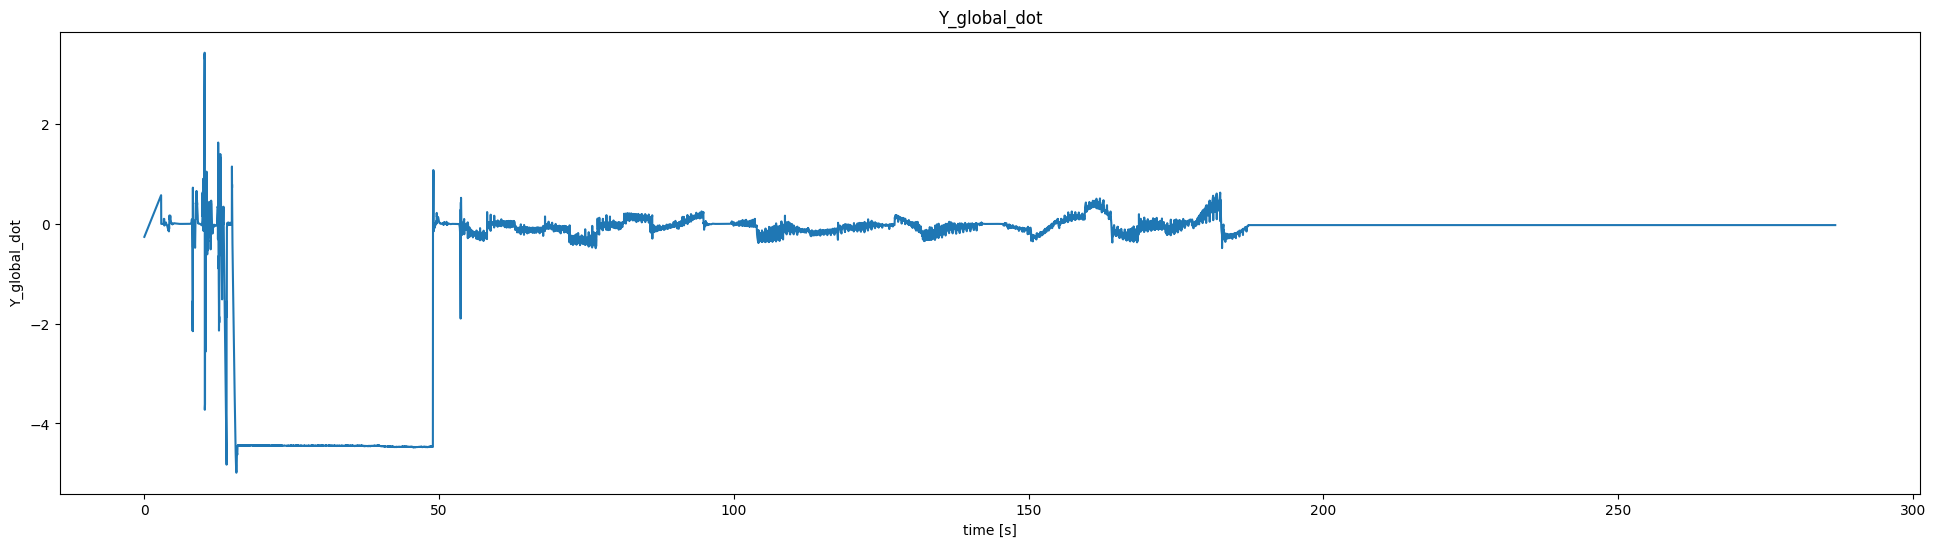

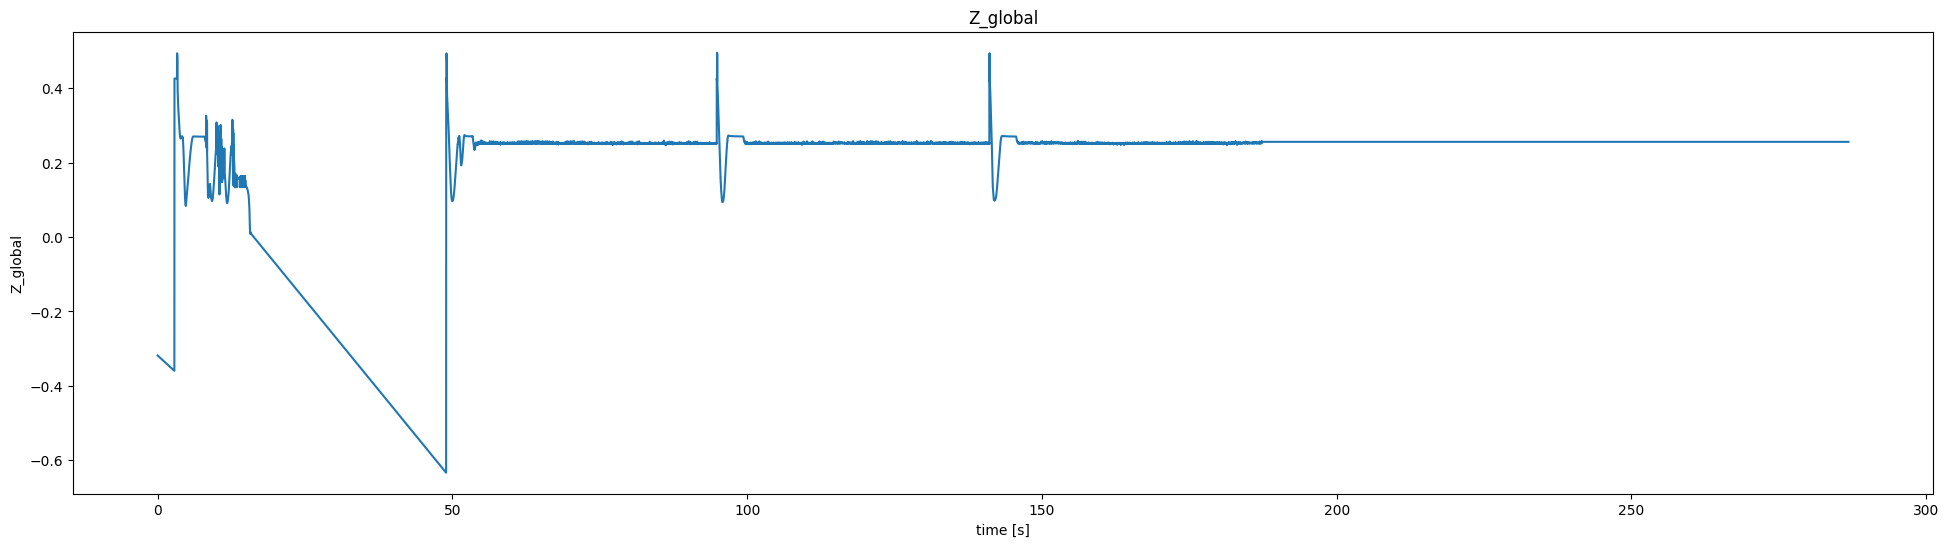

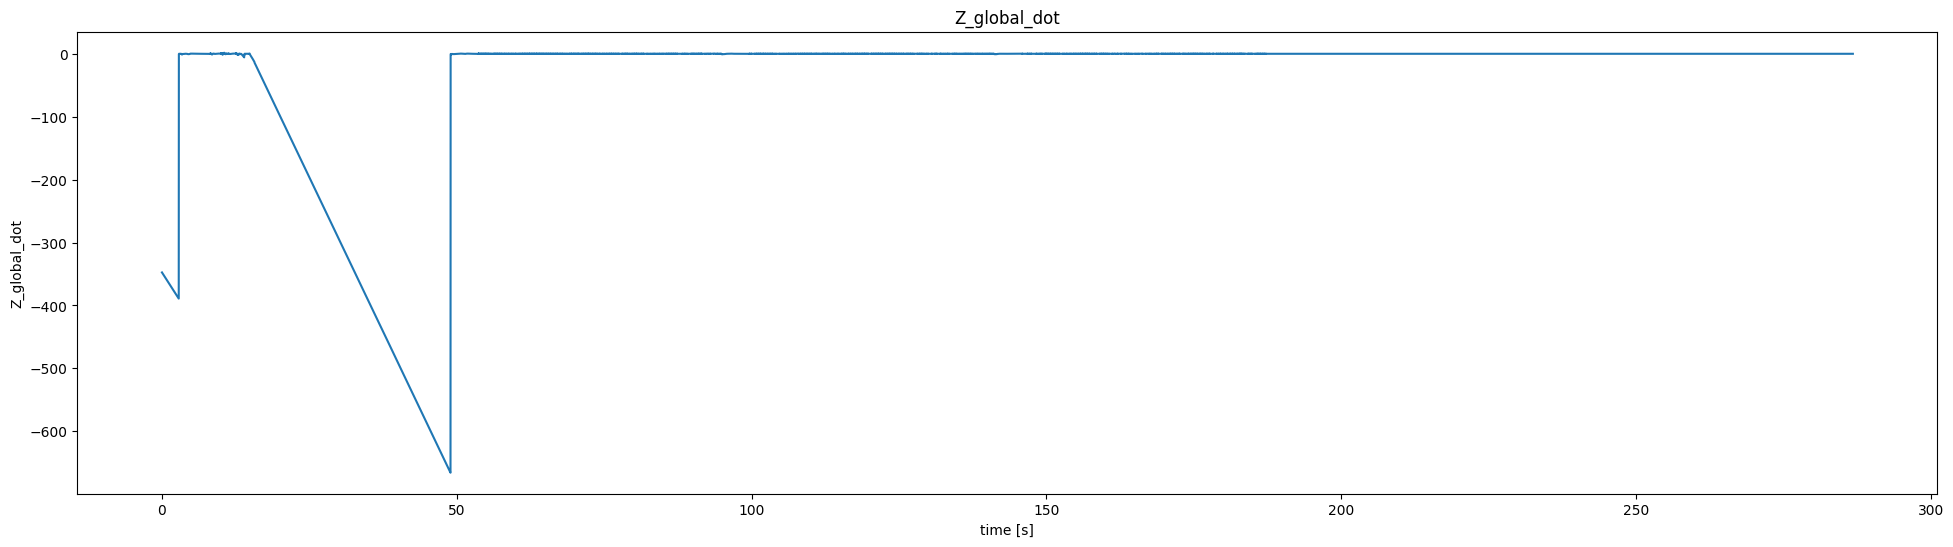

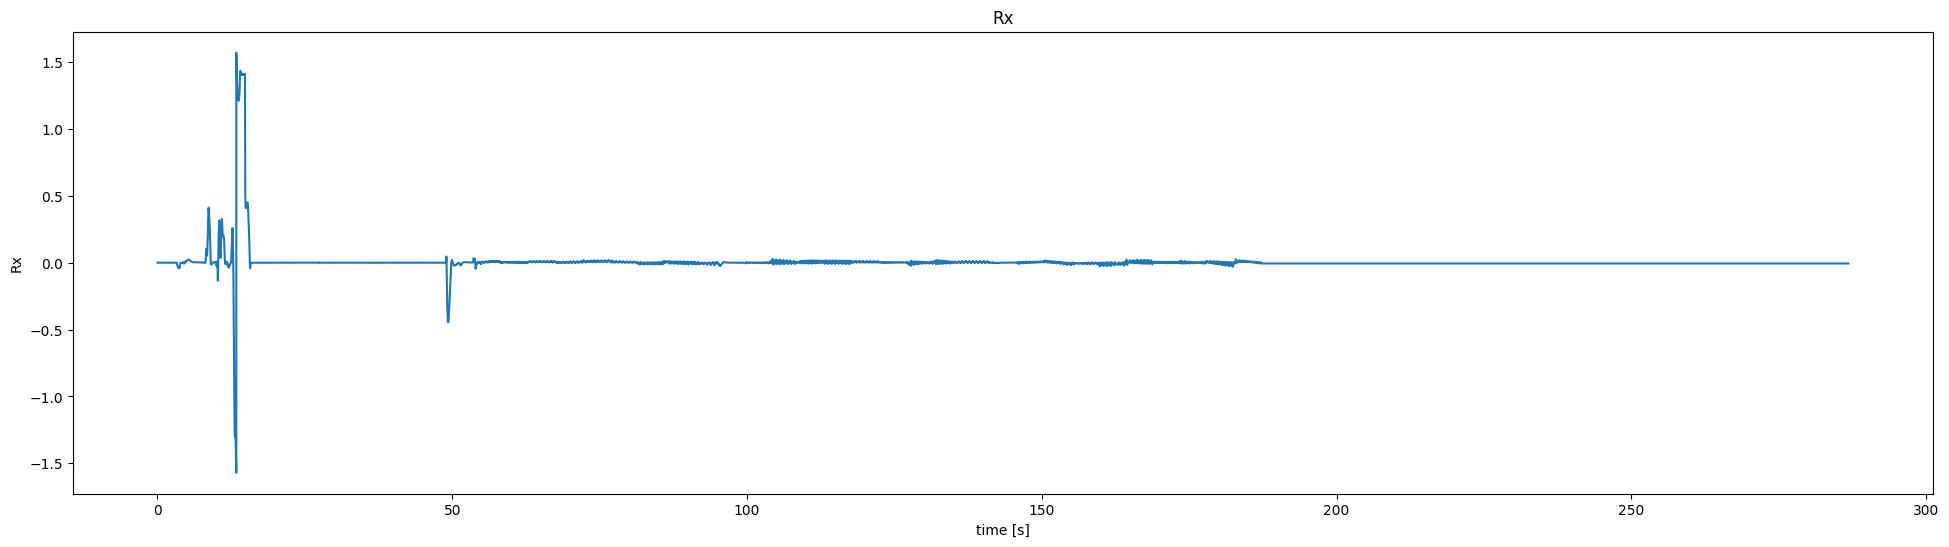

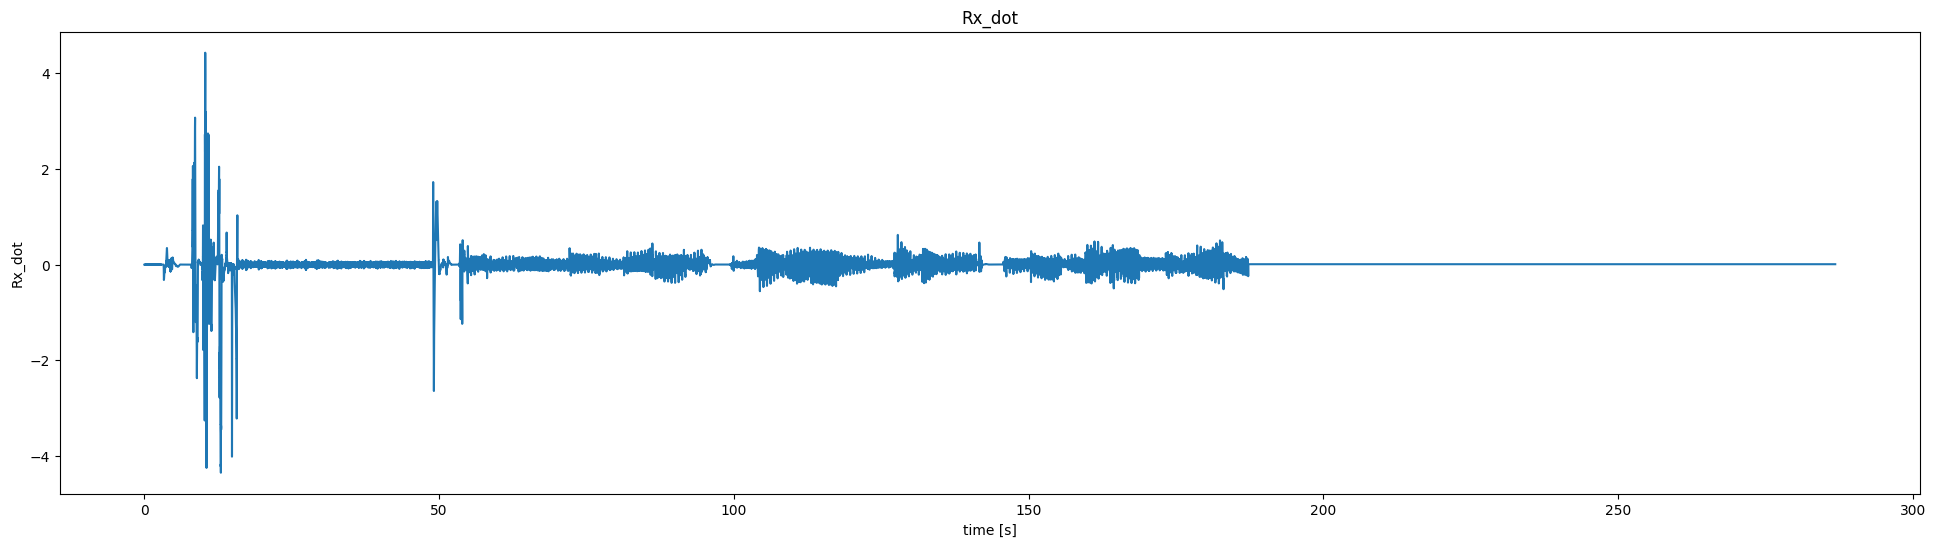

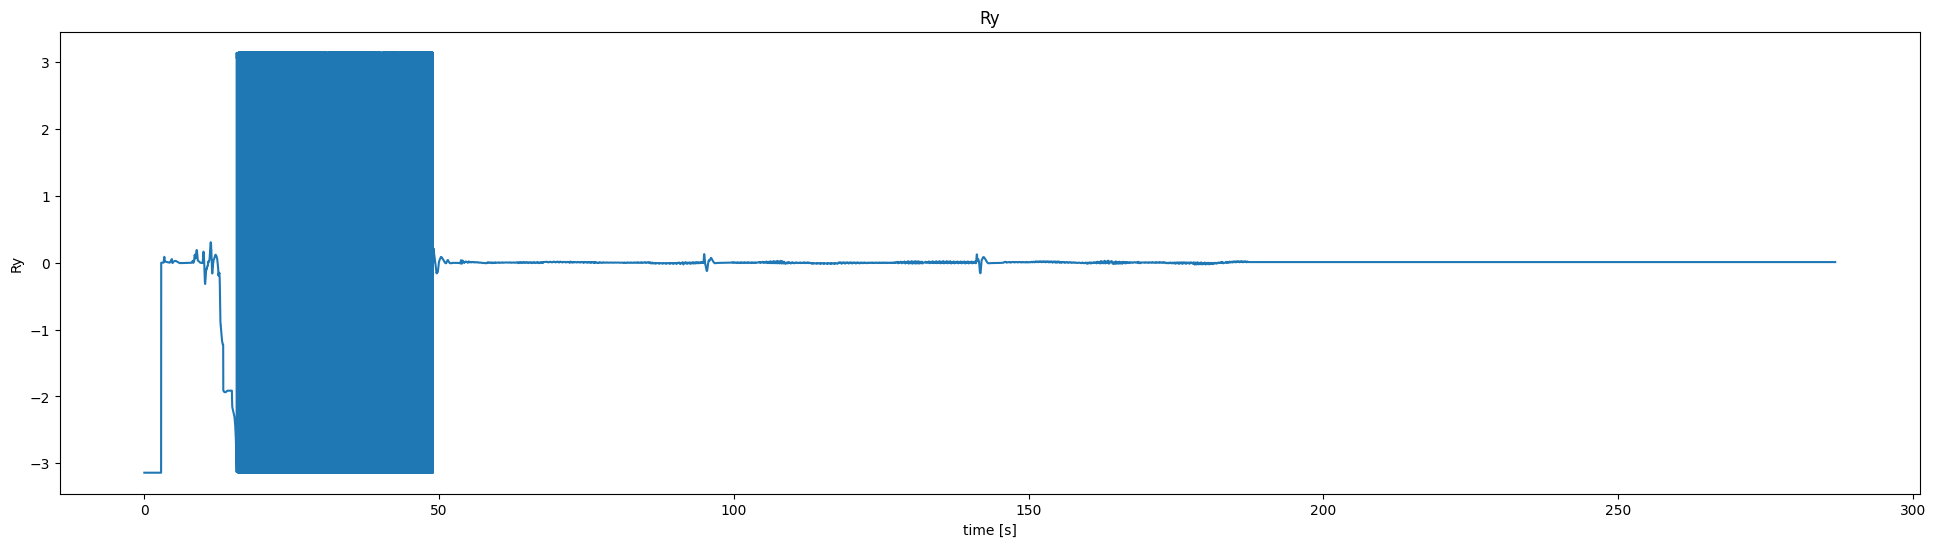

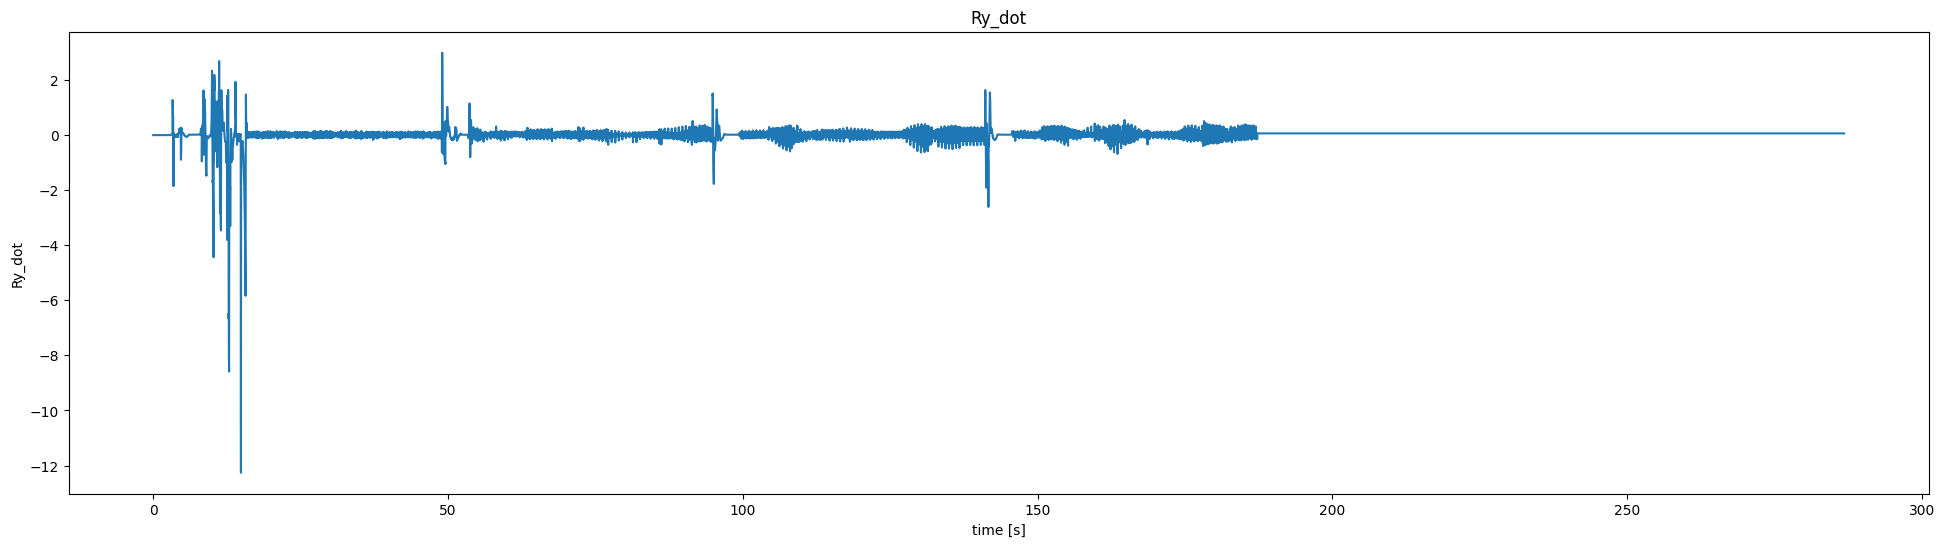

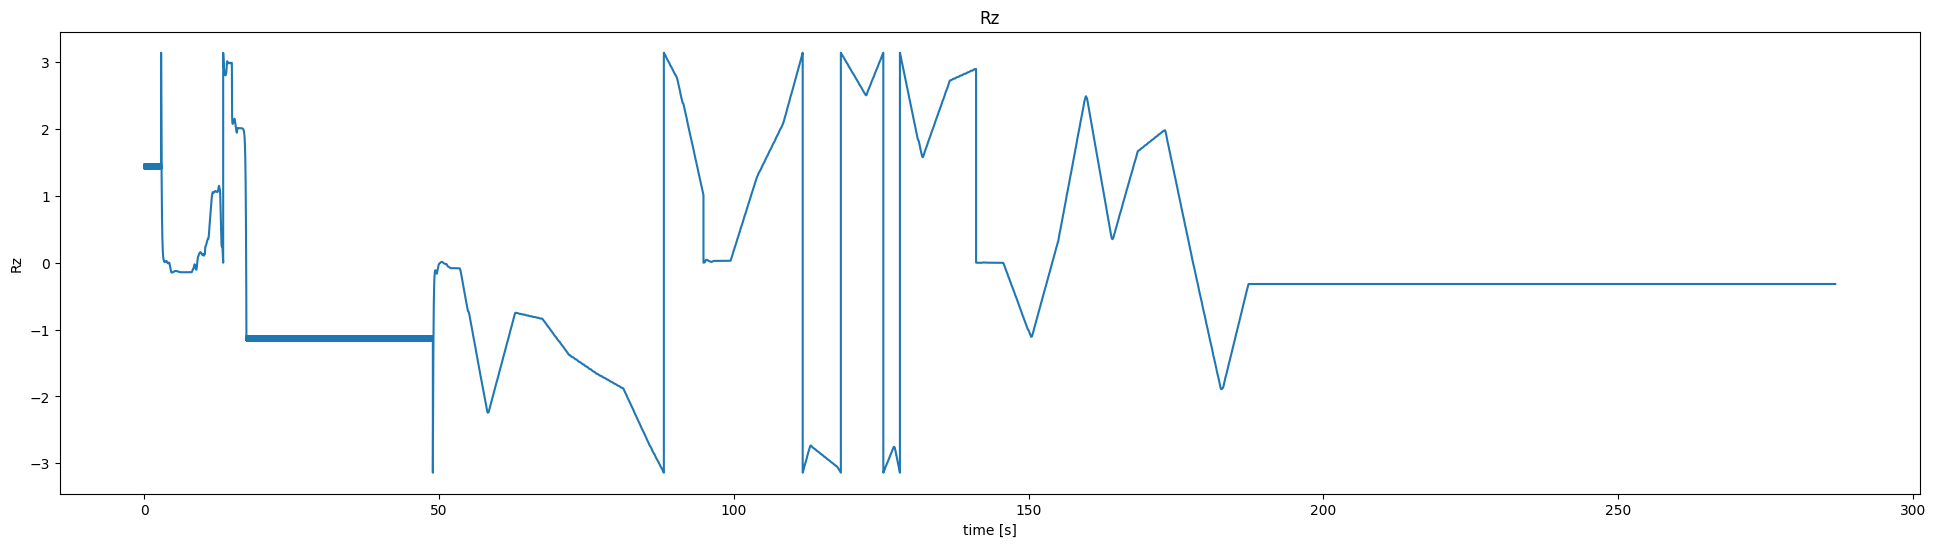

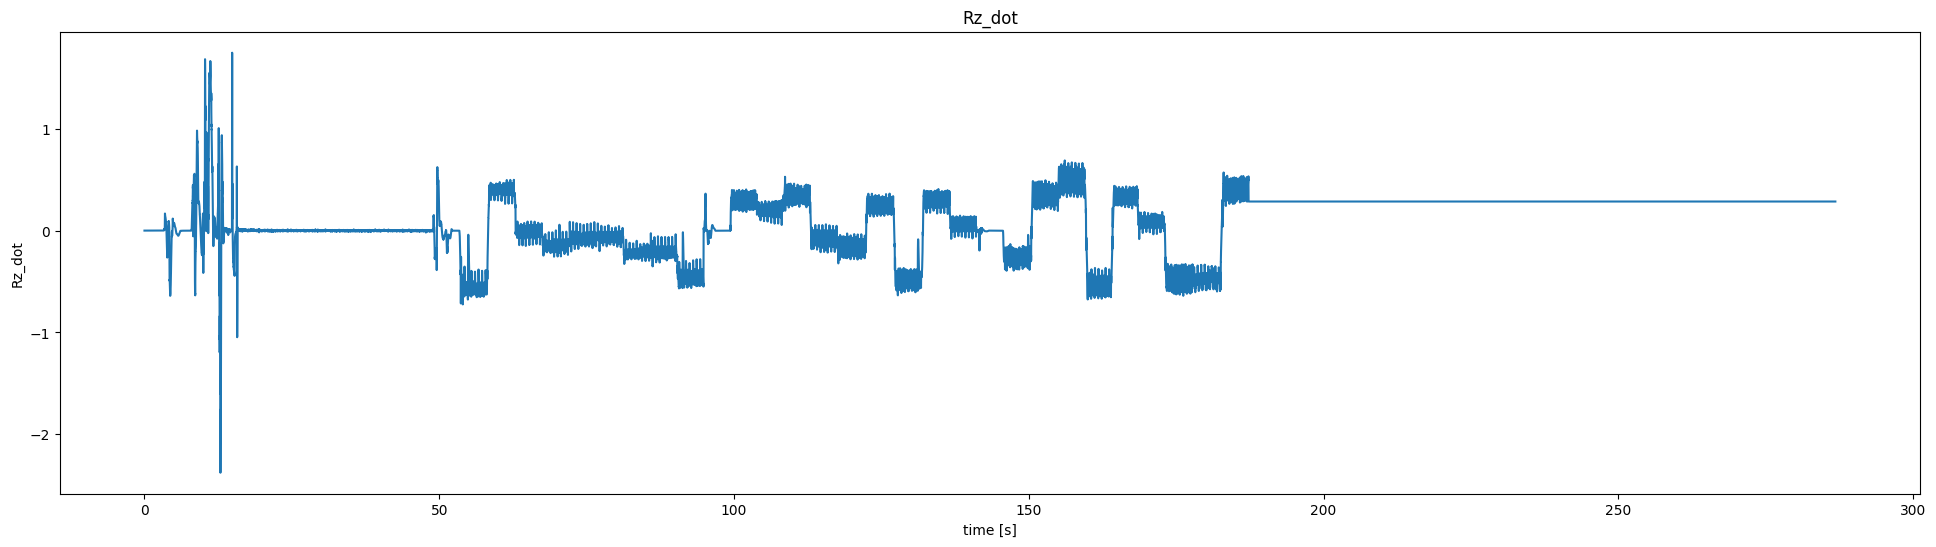

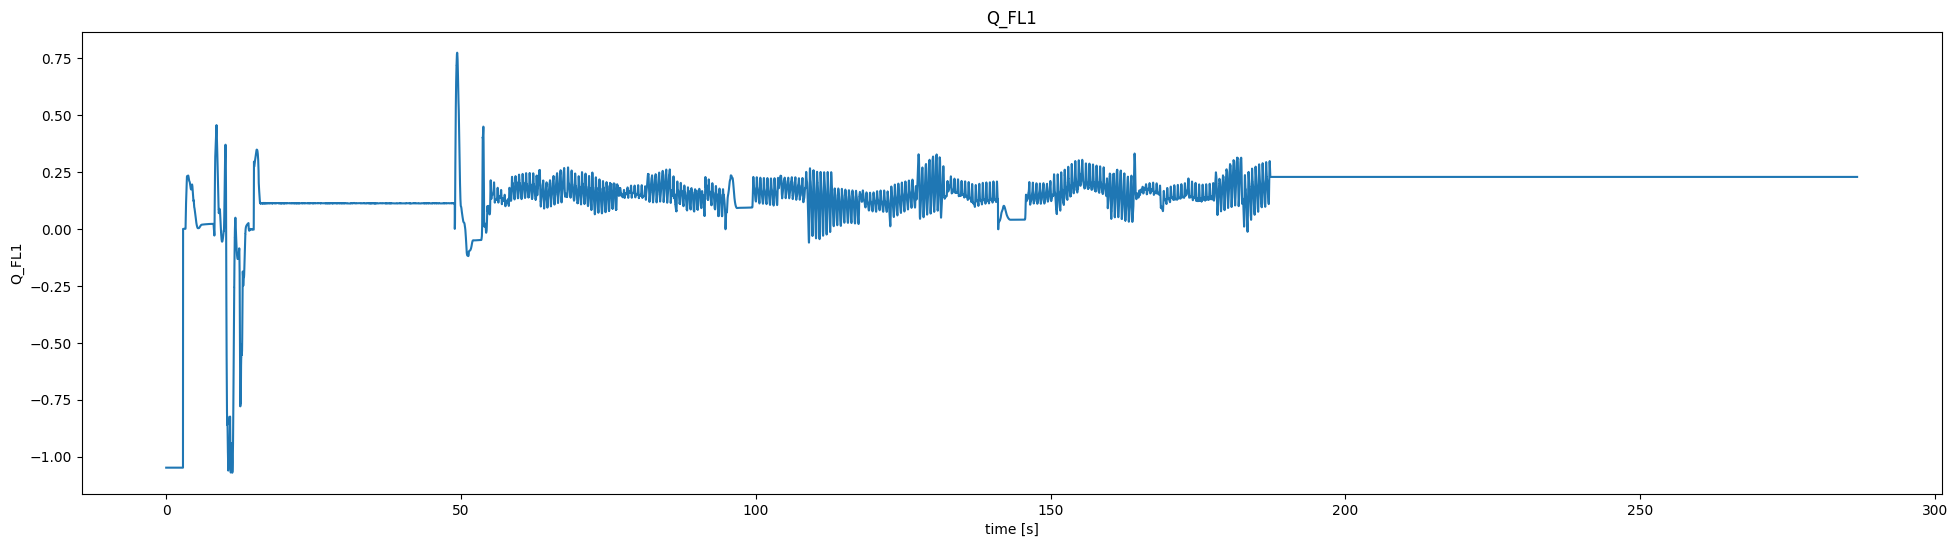

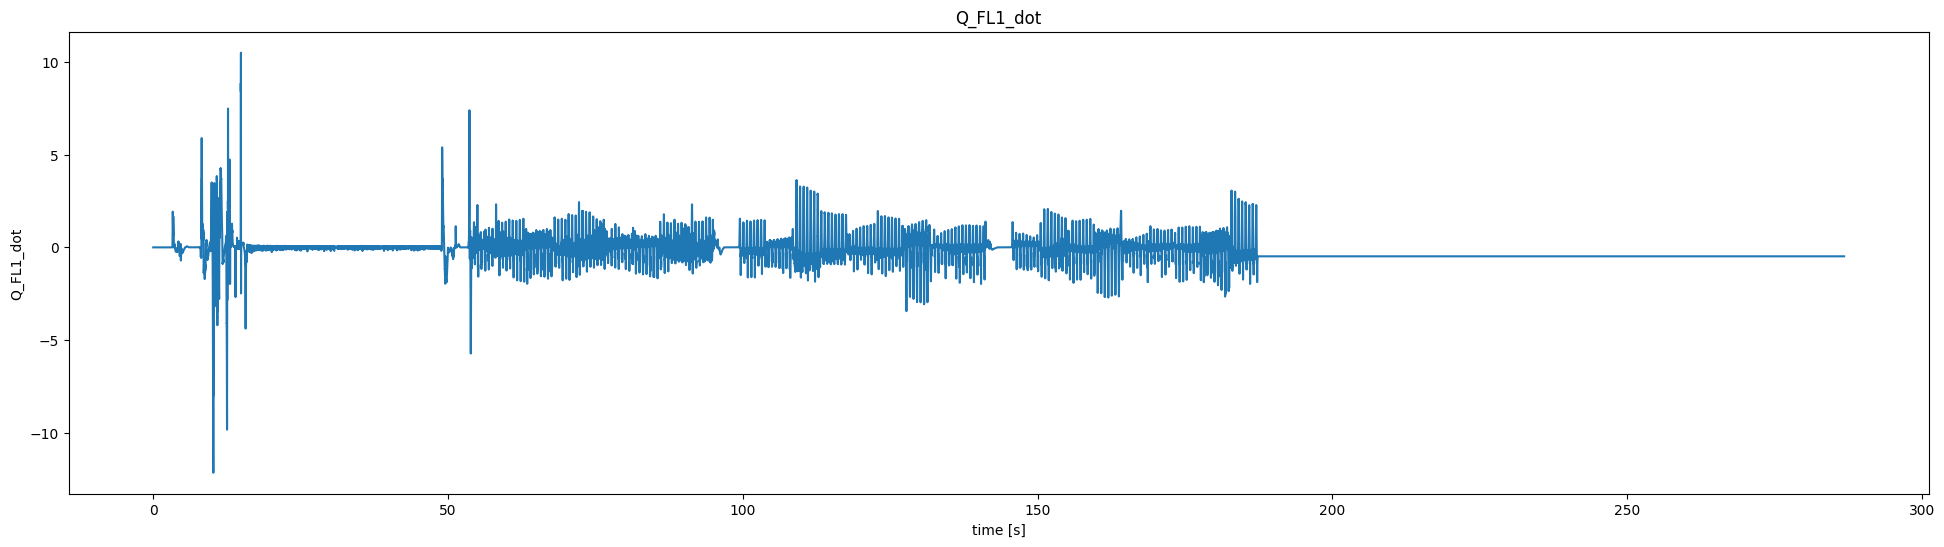

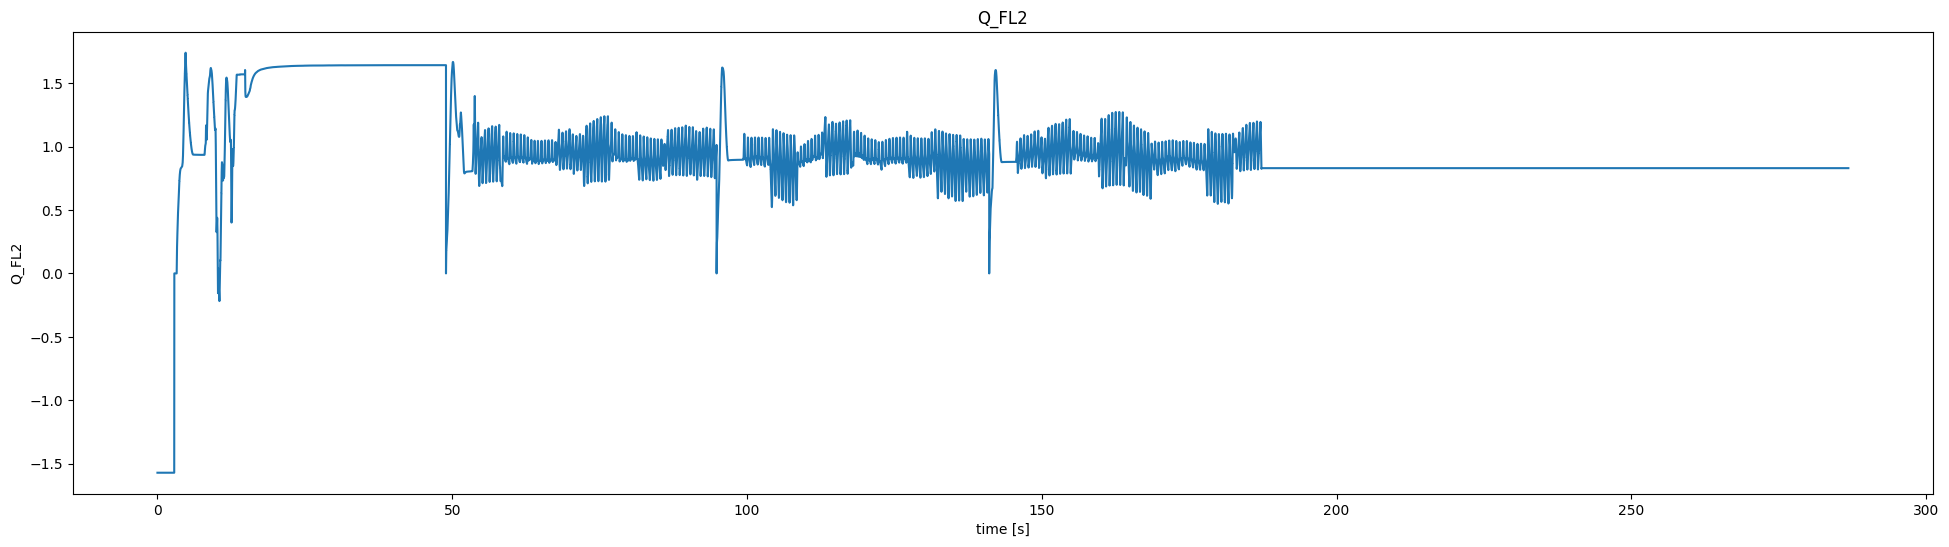

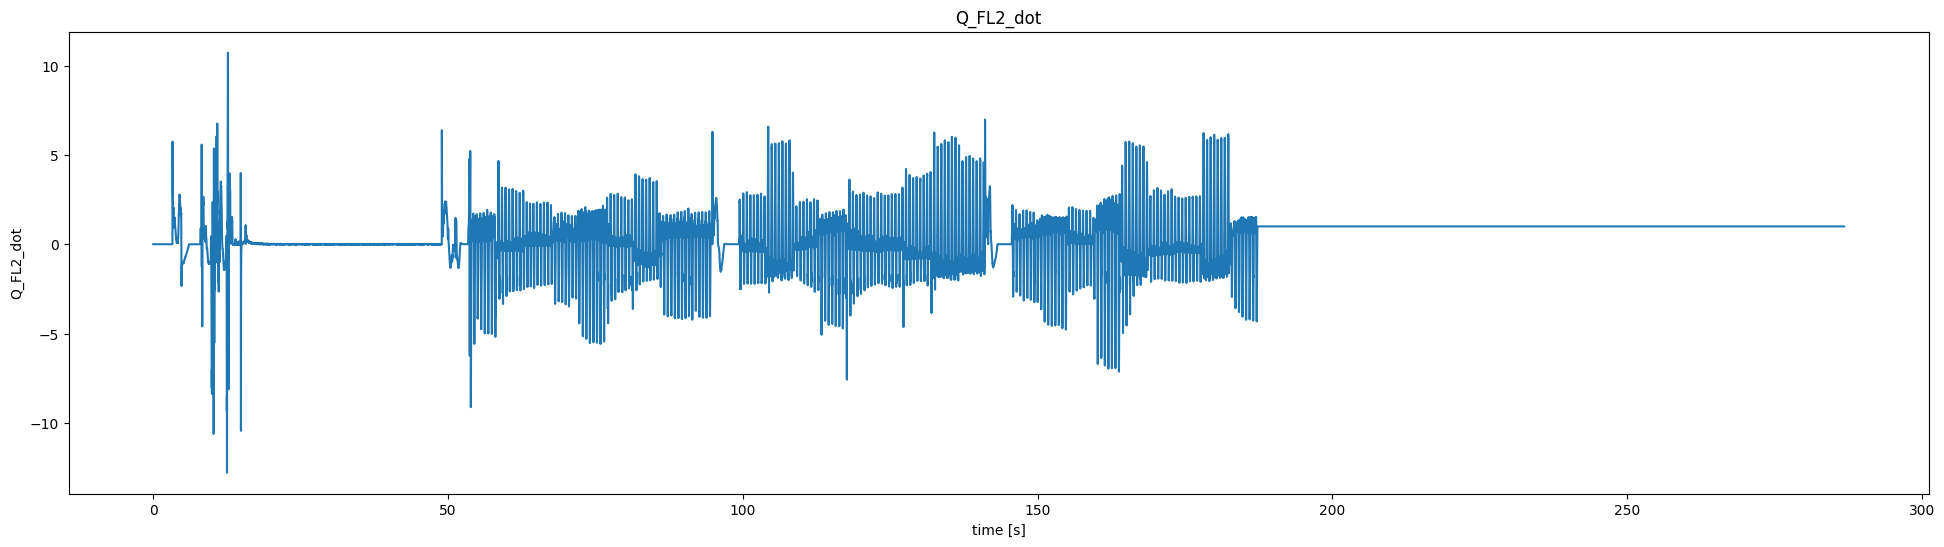

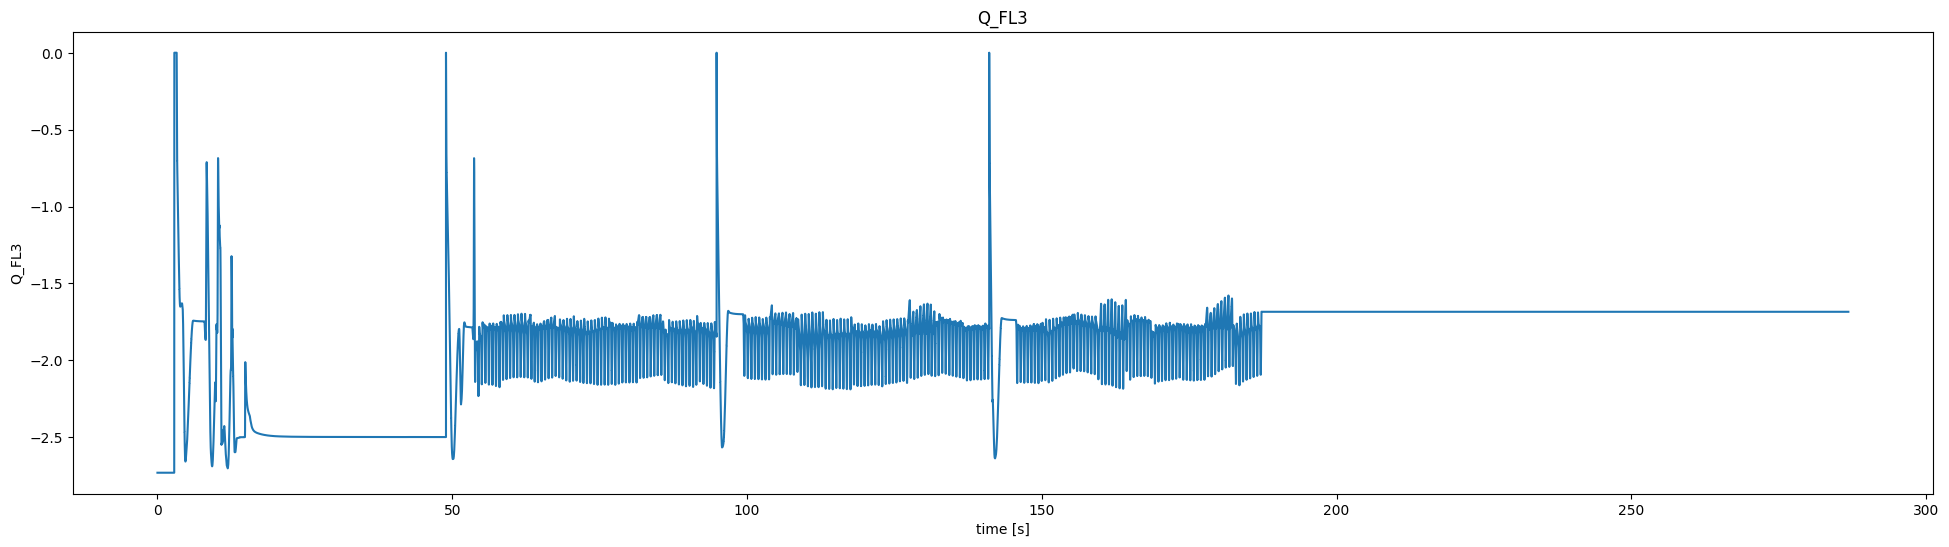

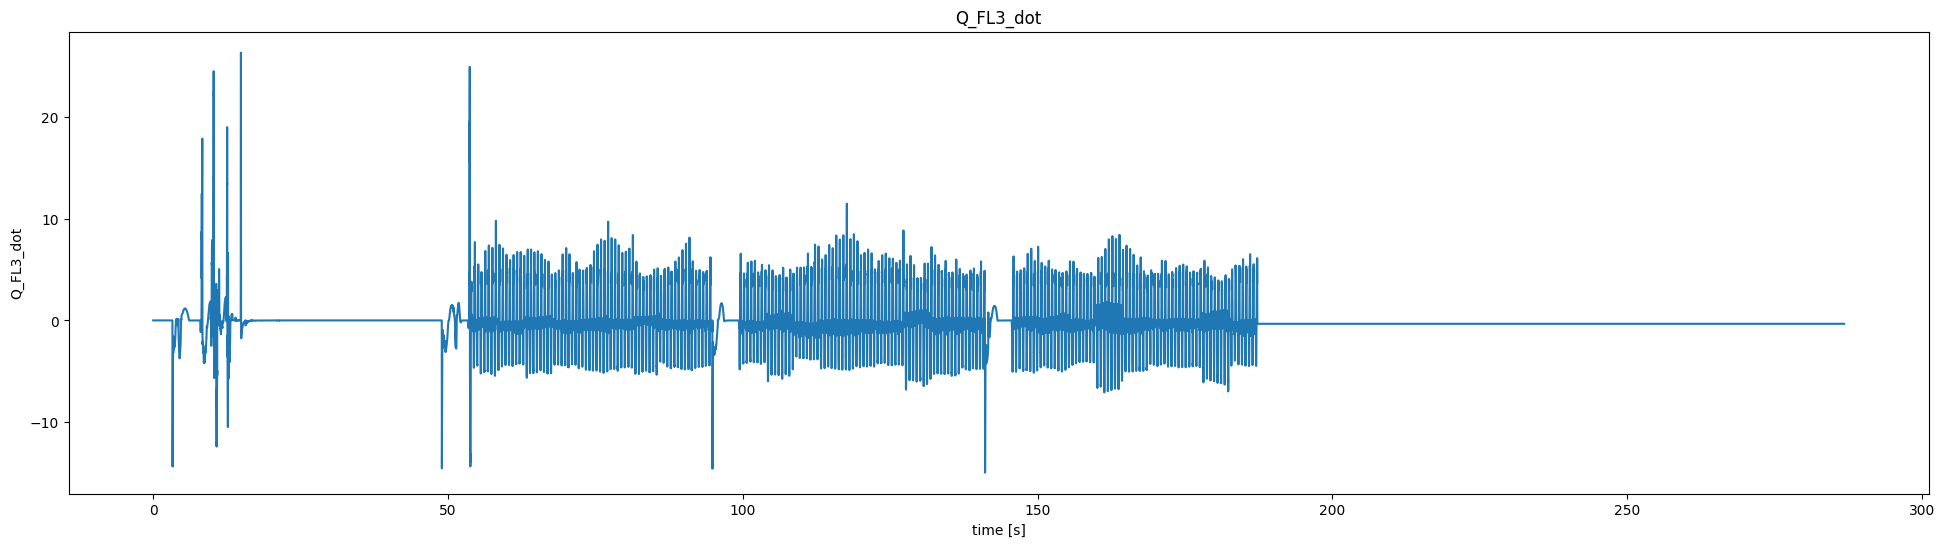

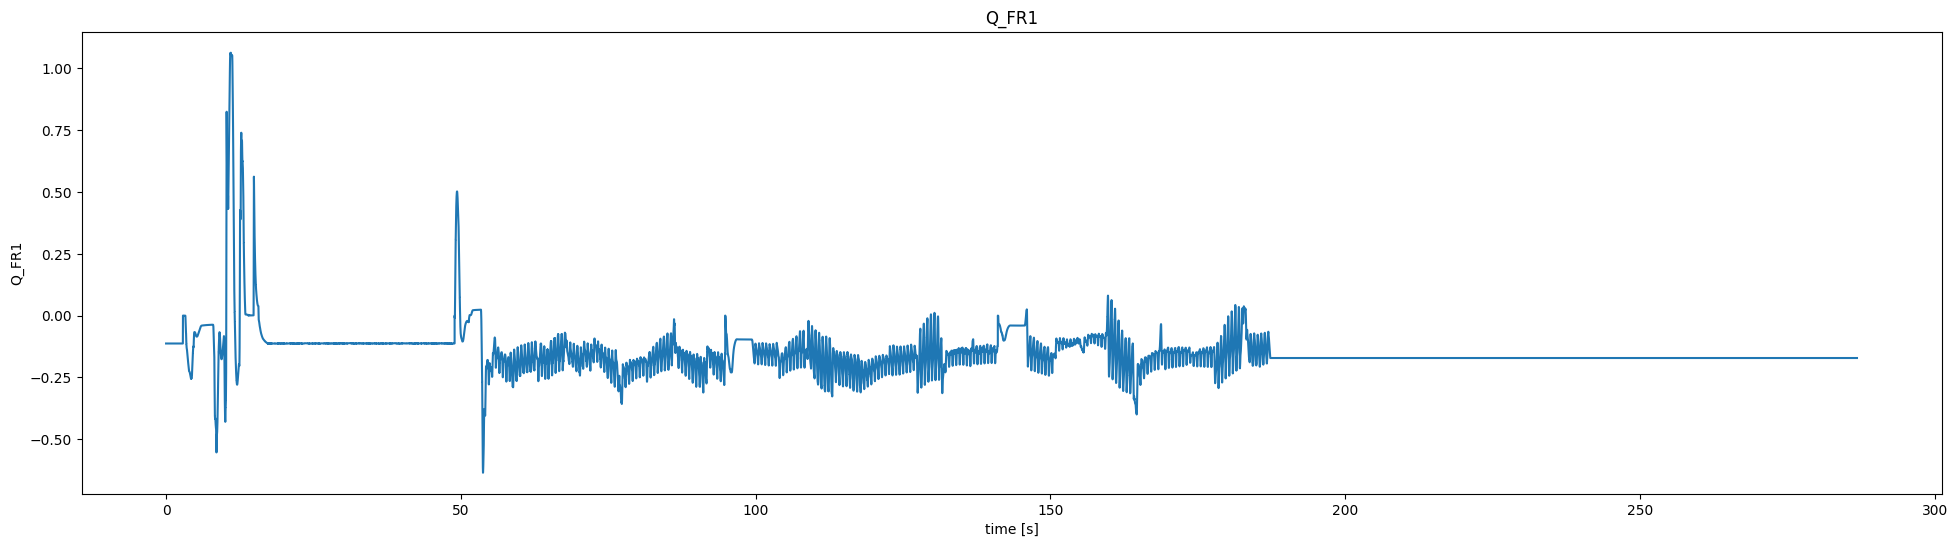

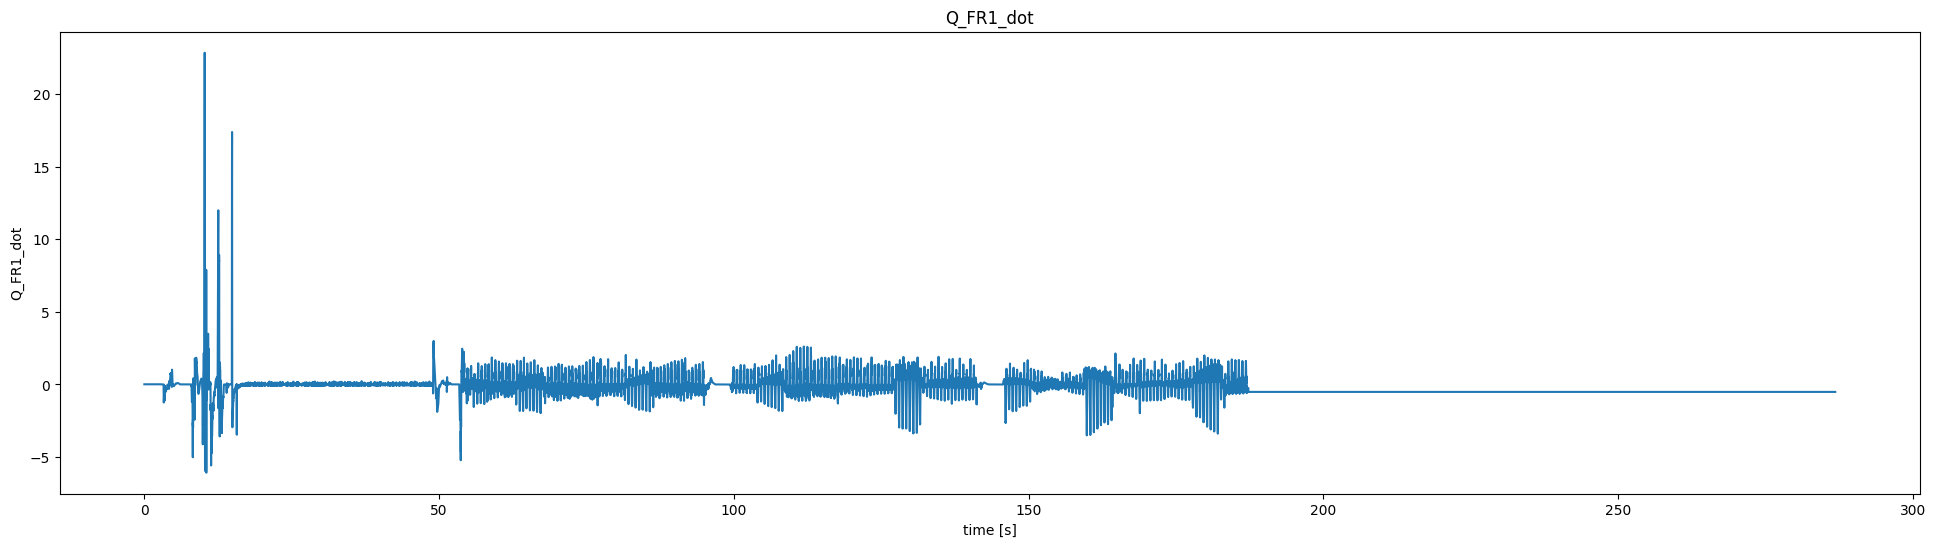

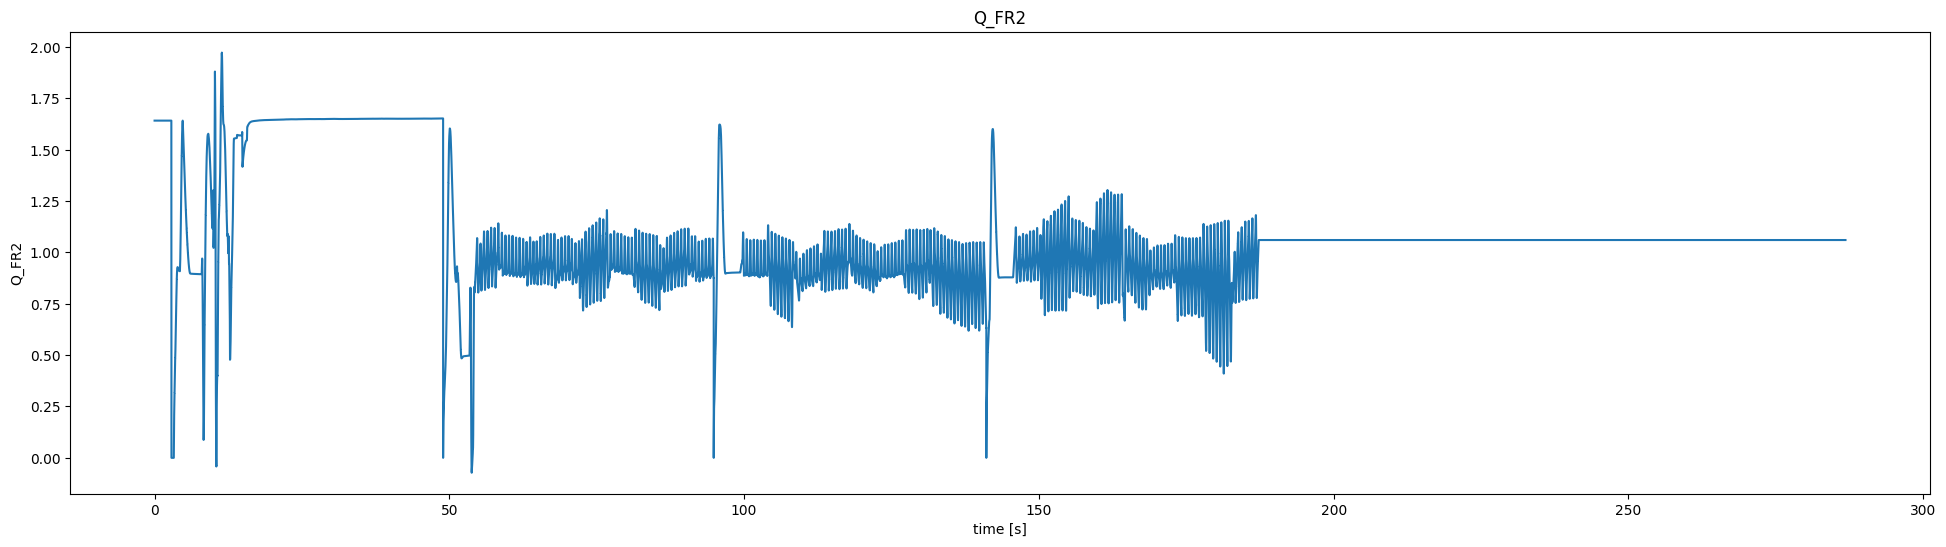

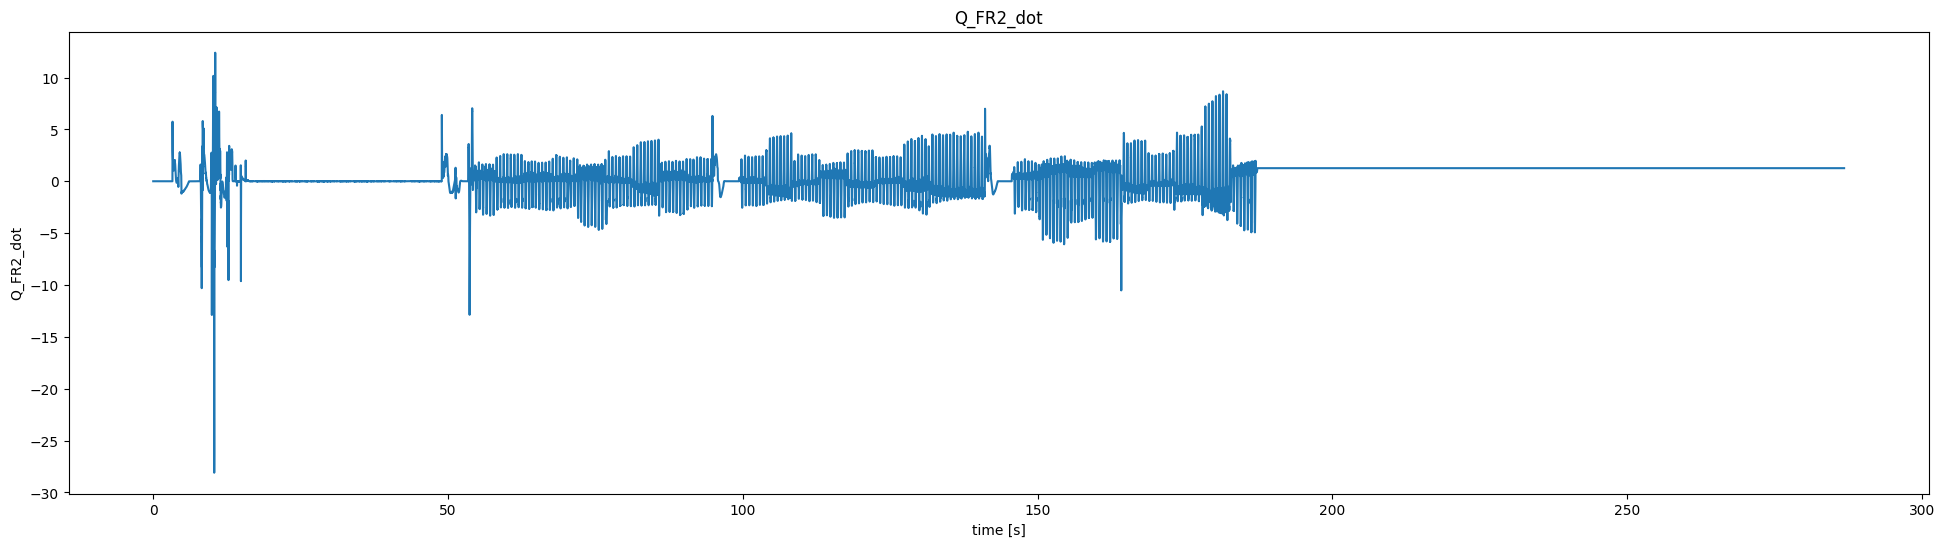

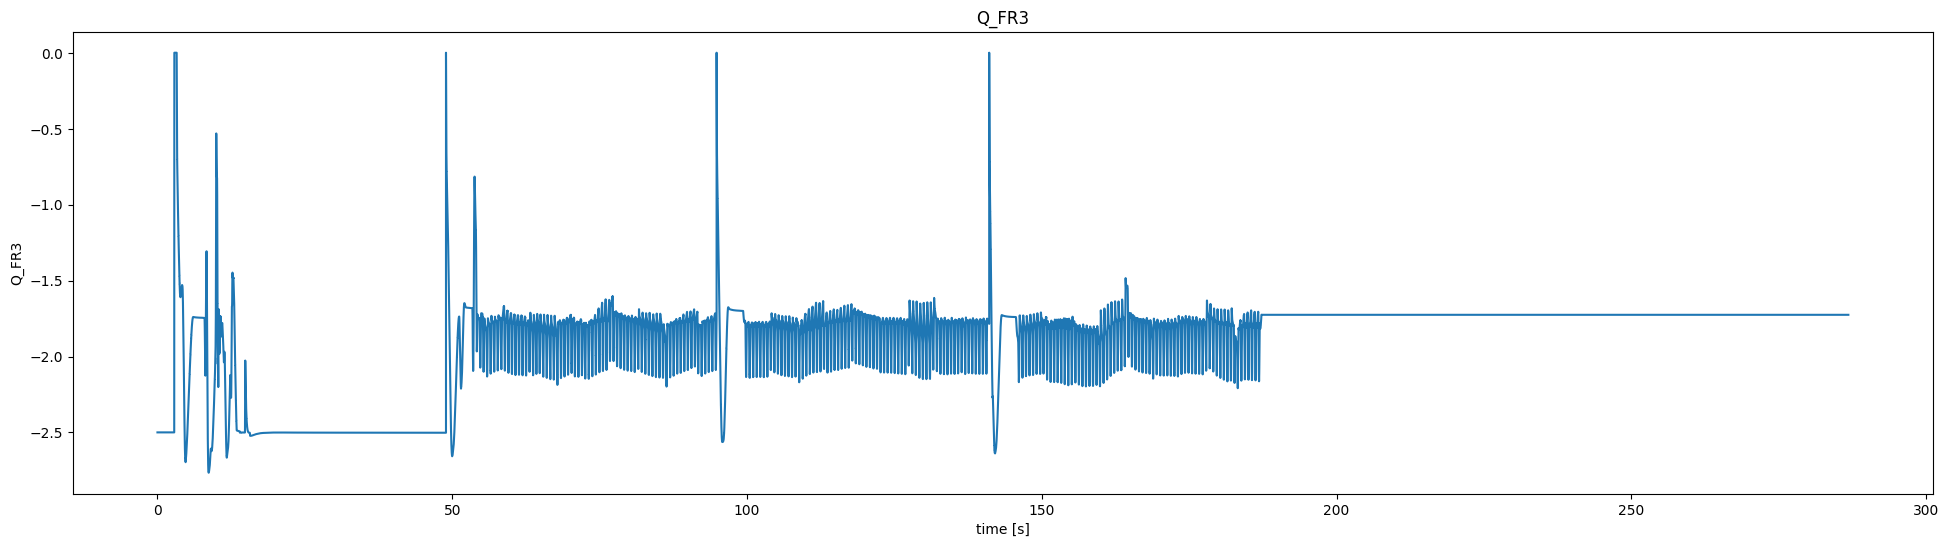

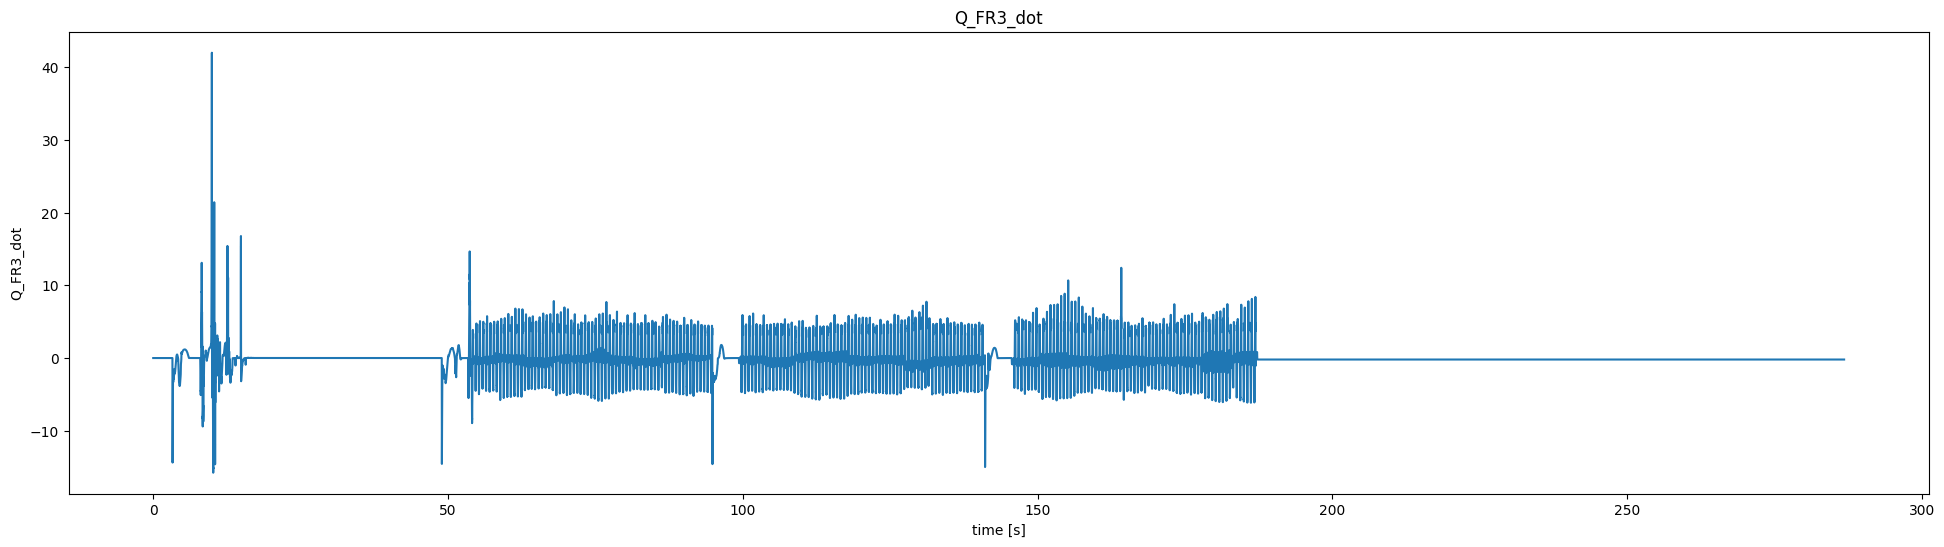

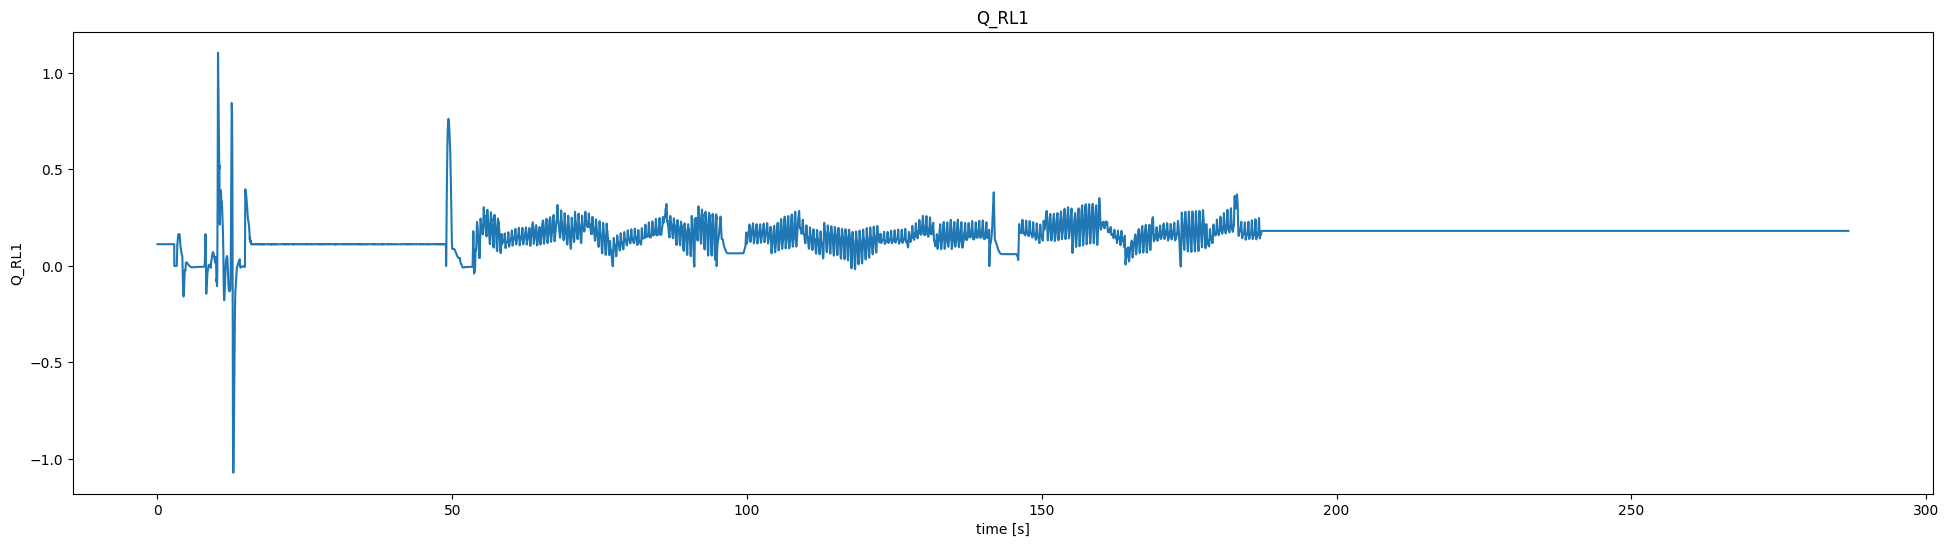

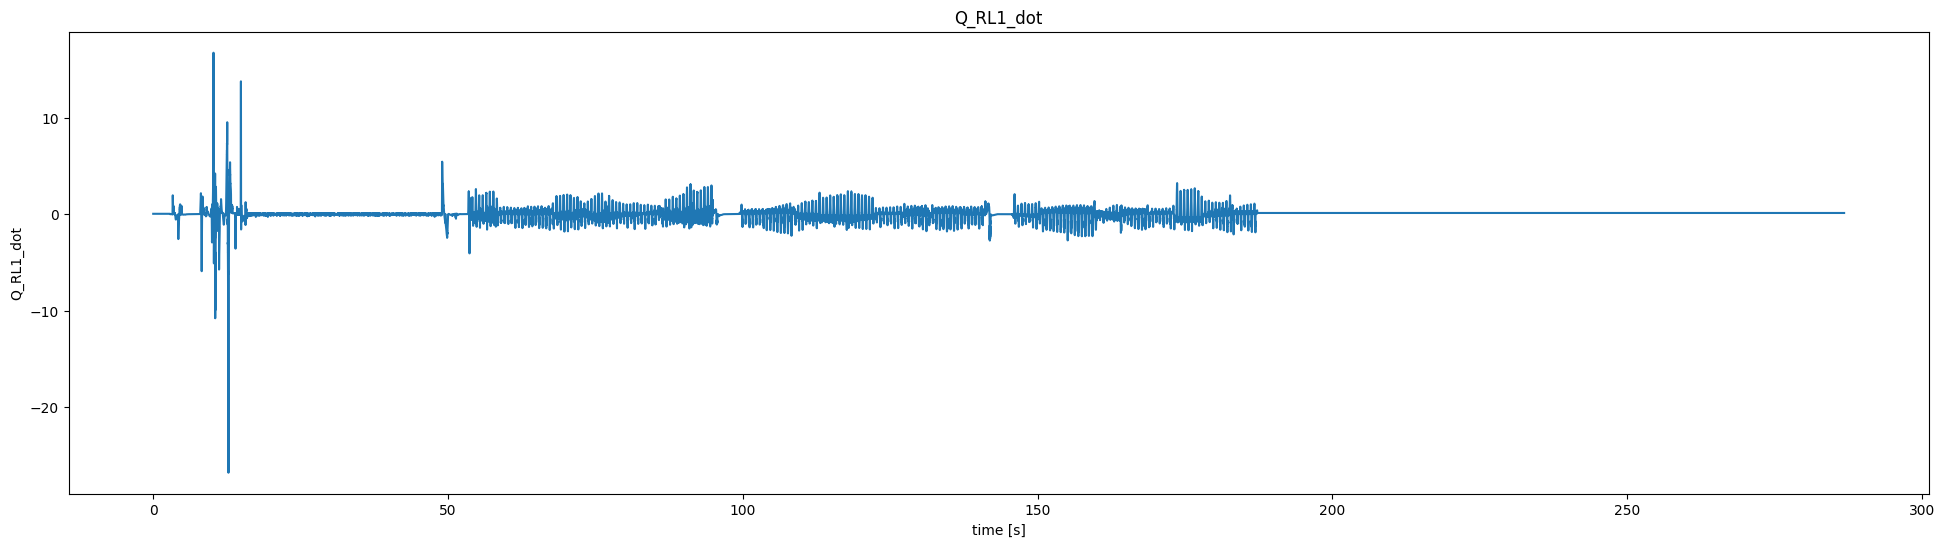

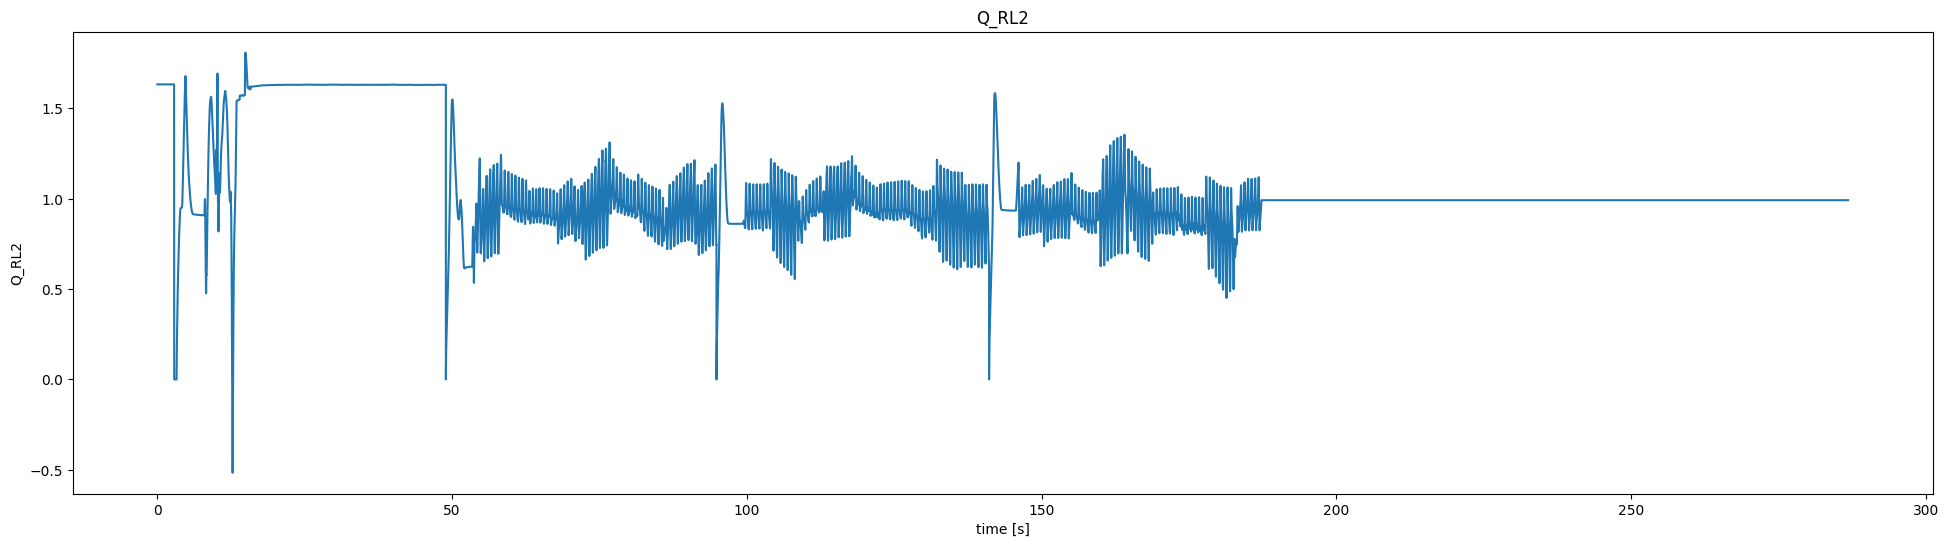

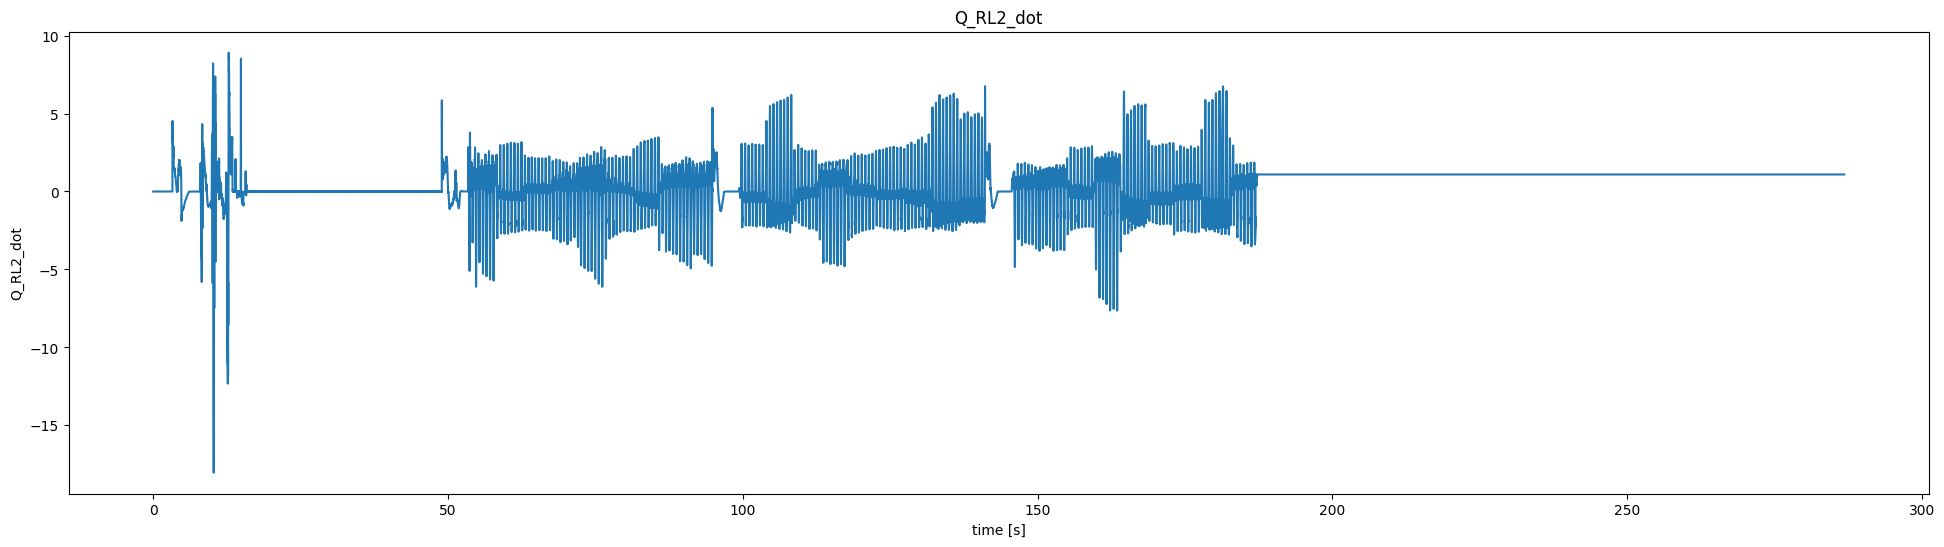

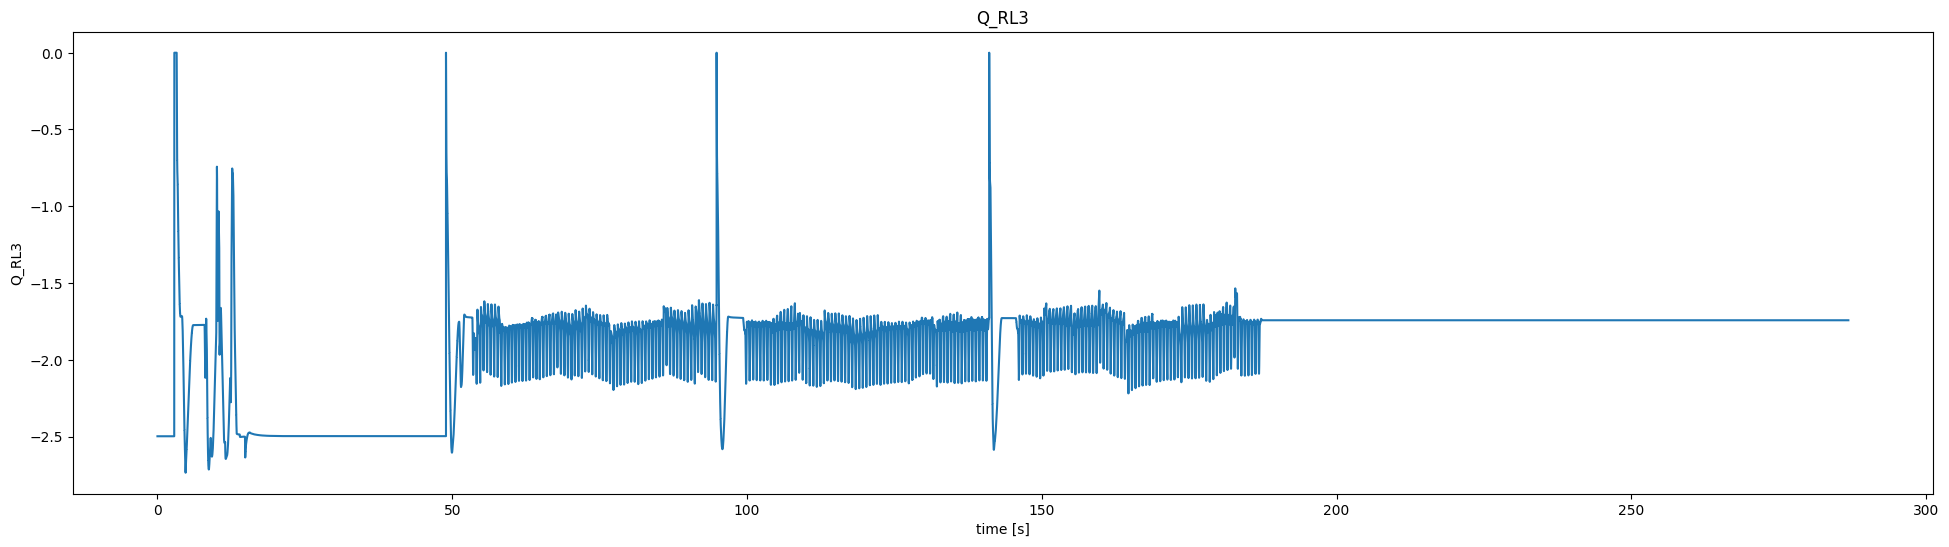

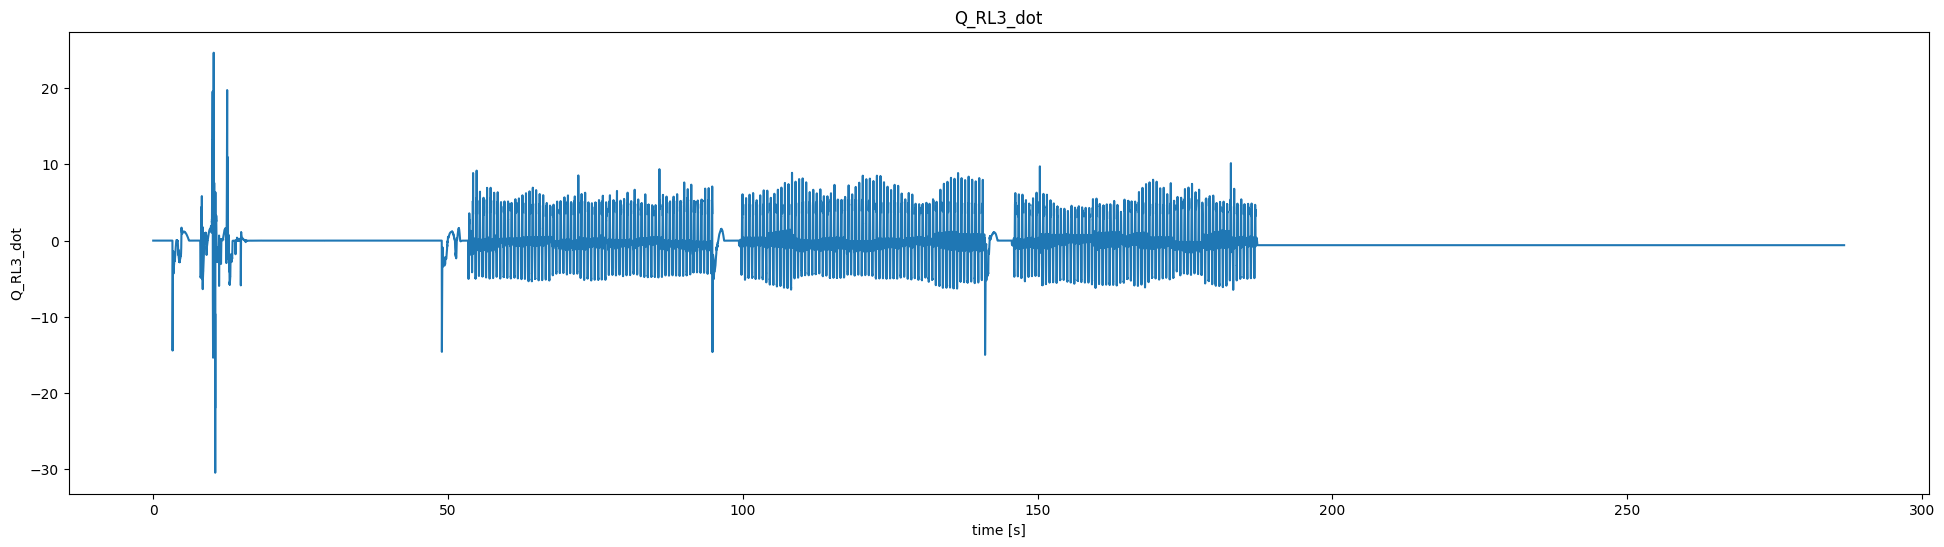

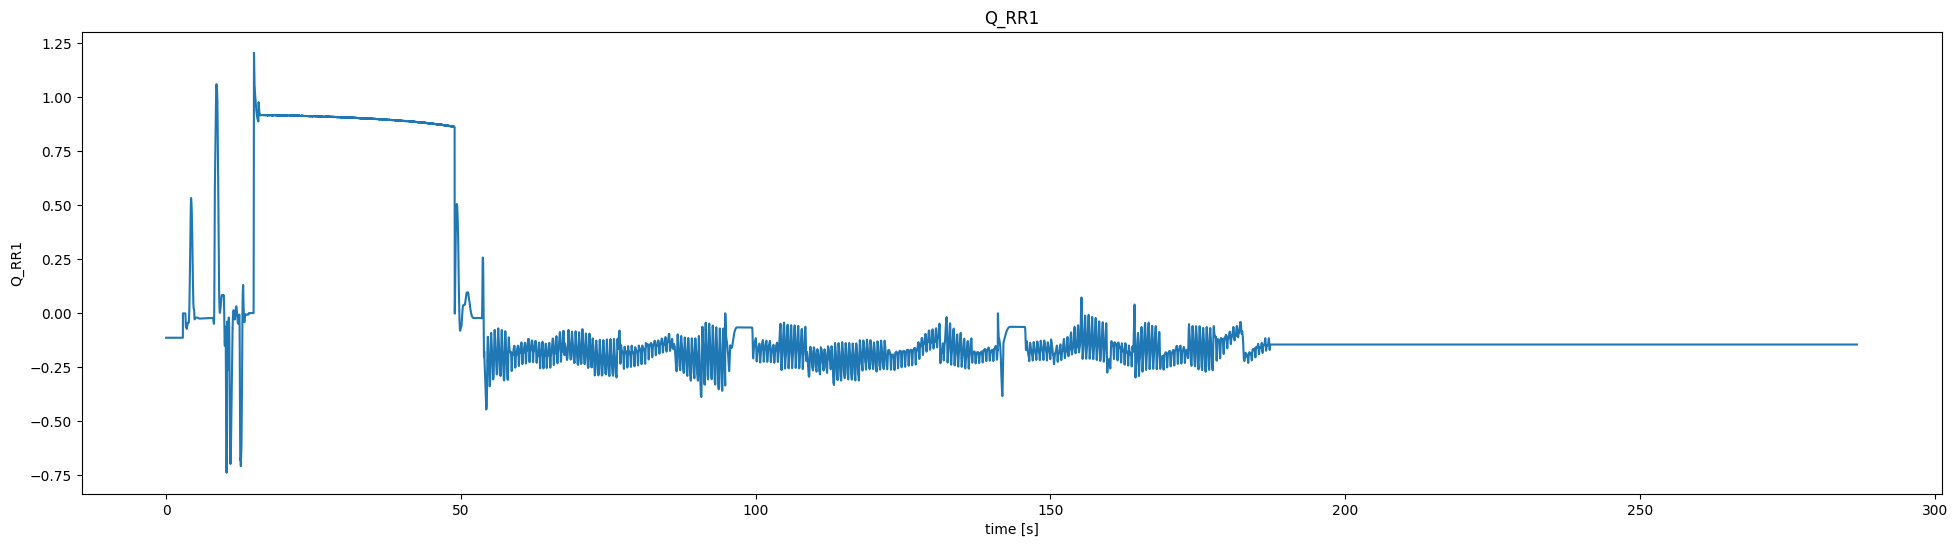

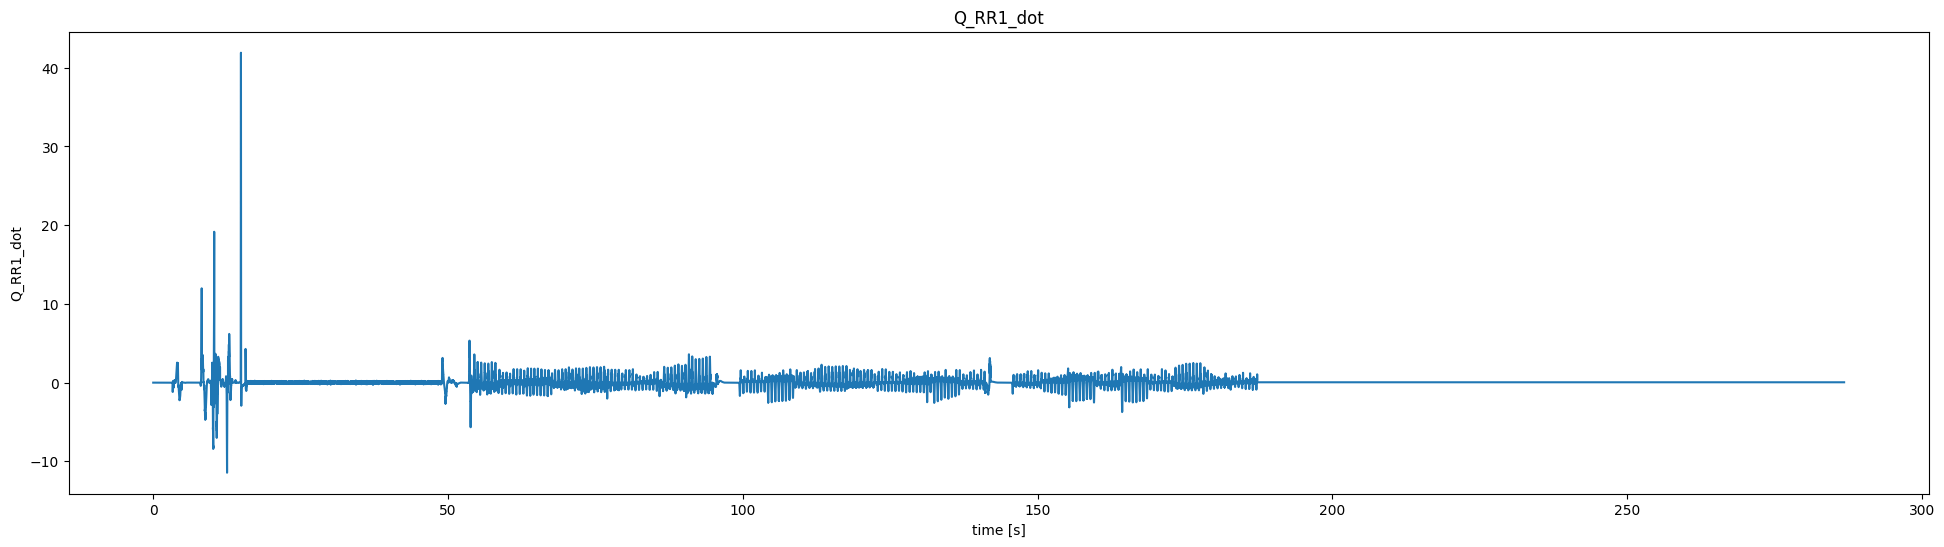

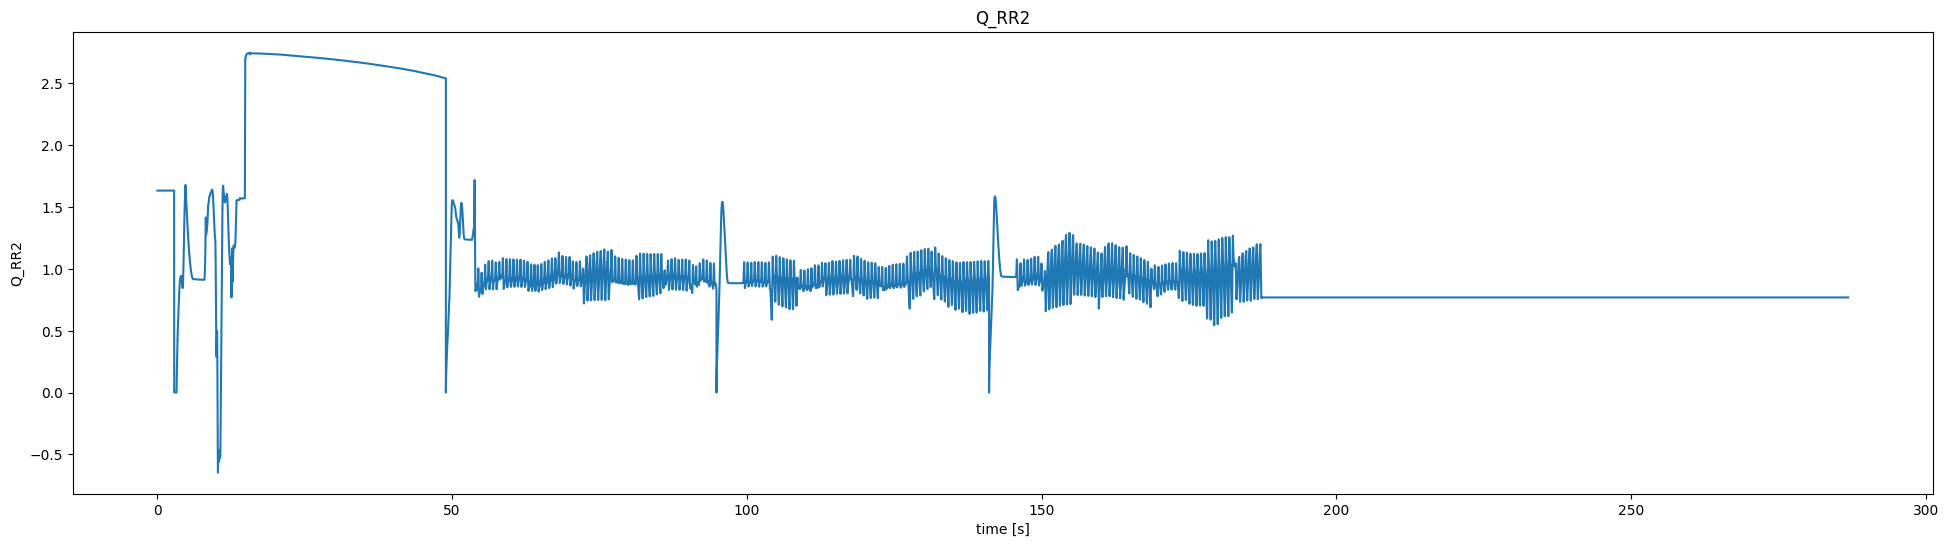

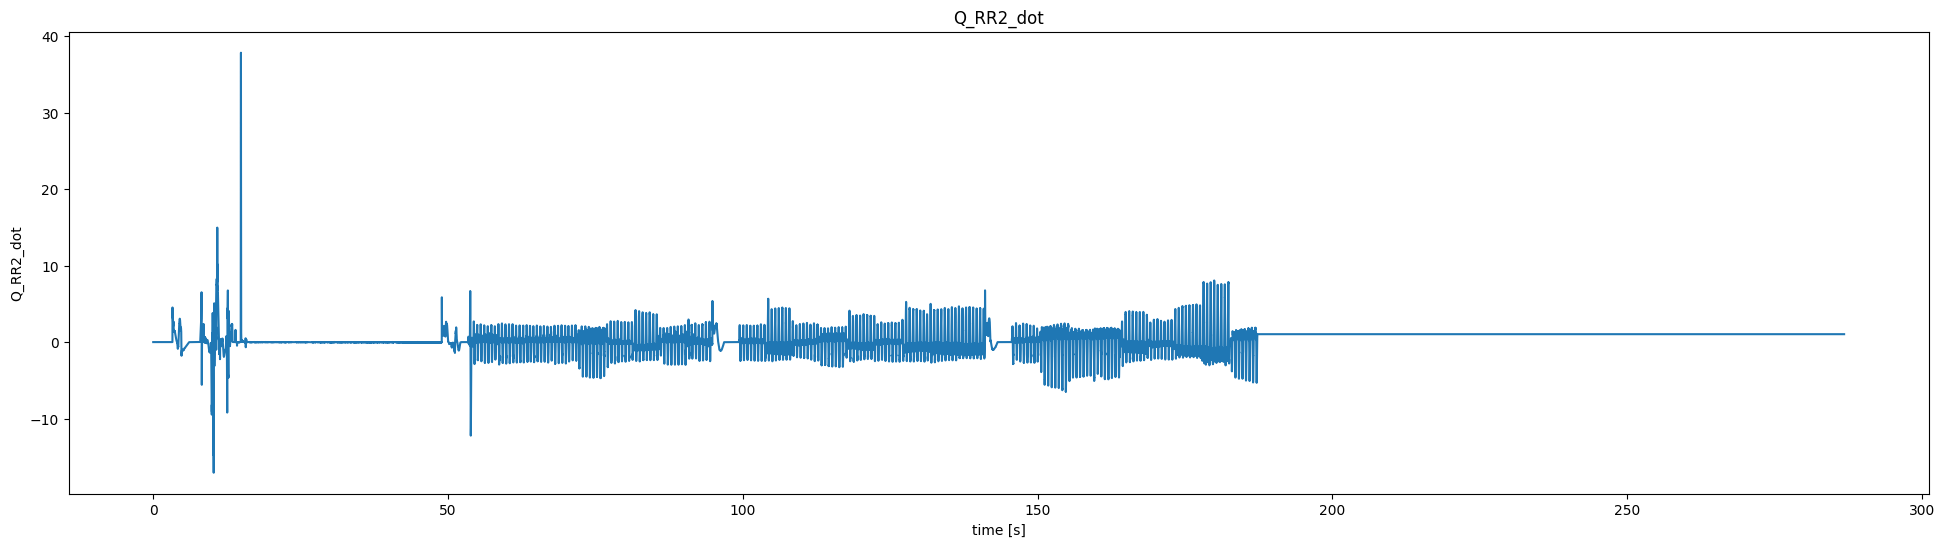

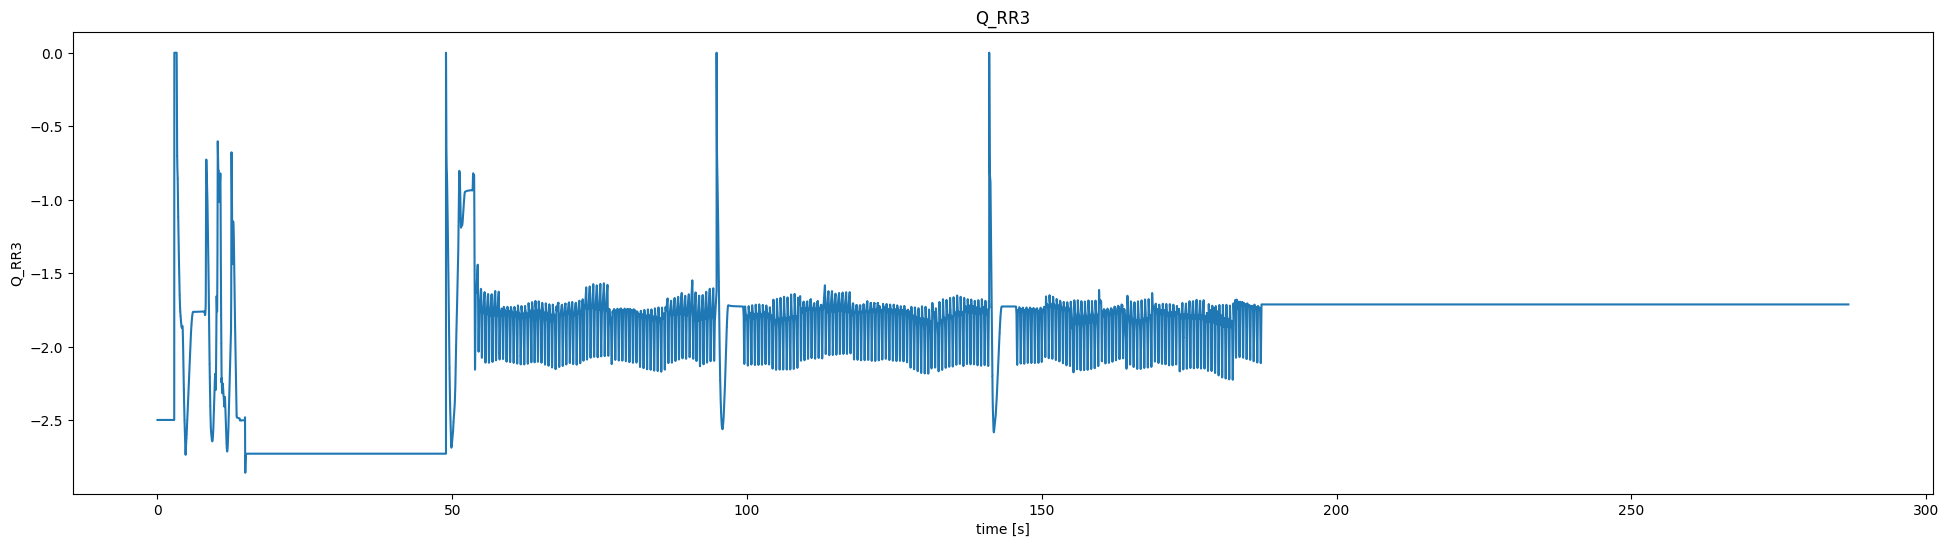

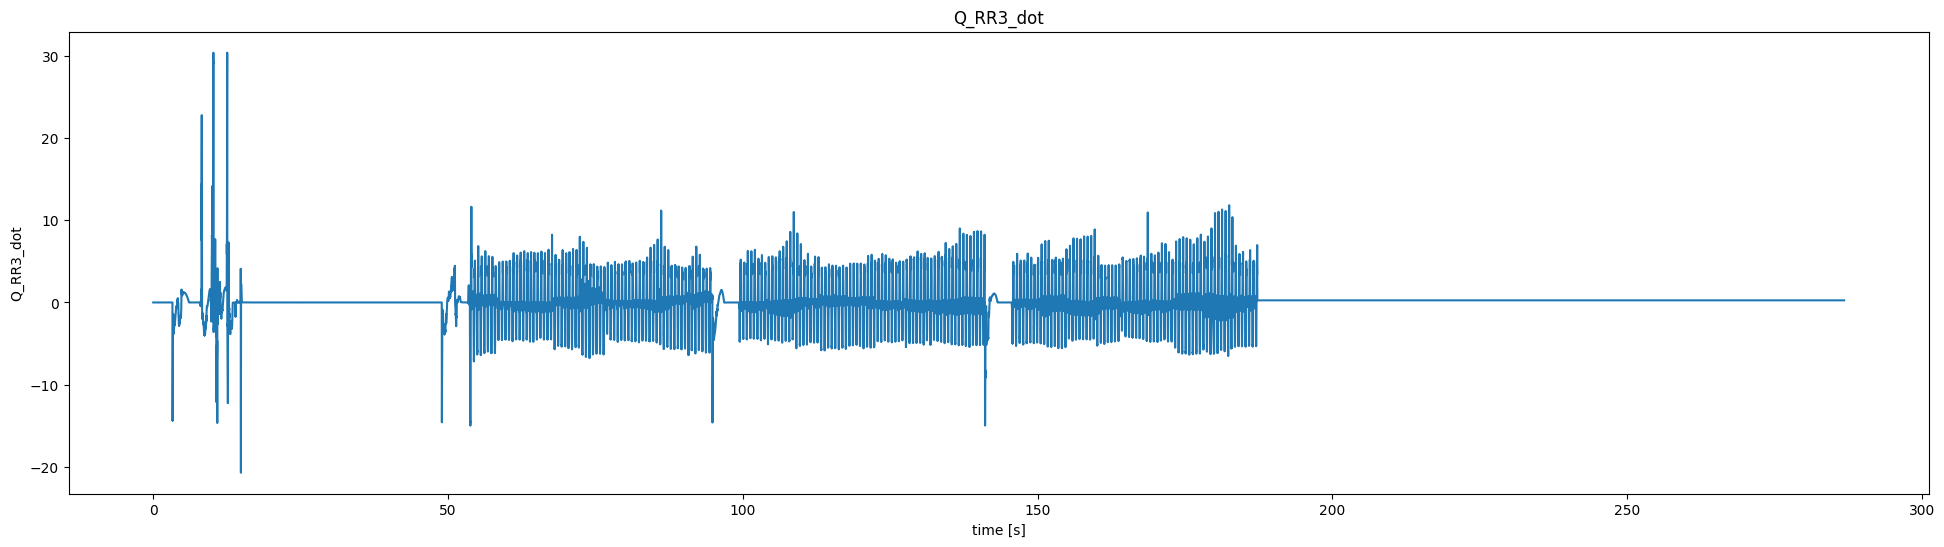

In [16]:
def PlotTimeserialData(time, data, name):
    plt.figure( figsize=[24, 6] )
    plt.ylabel( name )
    plt.title( name )
    plt.xlabel( "time [s]" )
    plt.plot( time, data )


for i in range(dim):
    PlotTimeserialData(time, q[:, i], q_name[i])
    PlotTimeserialData(time, qd[:, i], qd_name[i])


### Data processing

Total number of scenes: 4.0
Number of timesteps in masked data: 161831
Shape of Rot Mtx arr: (161831, 3, 3)
(34424, 32)


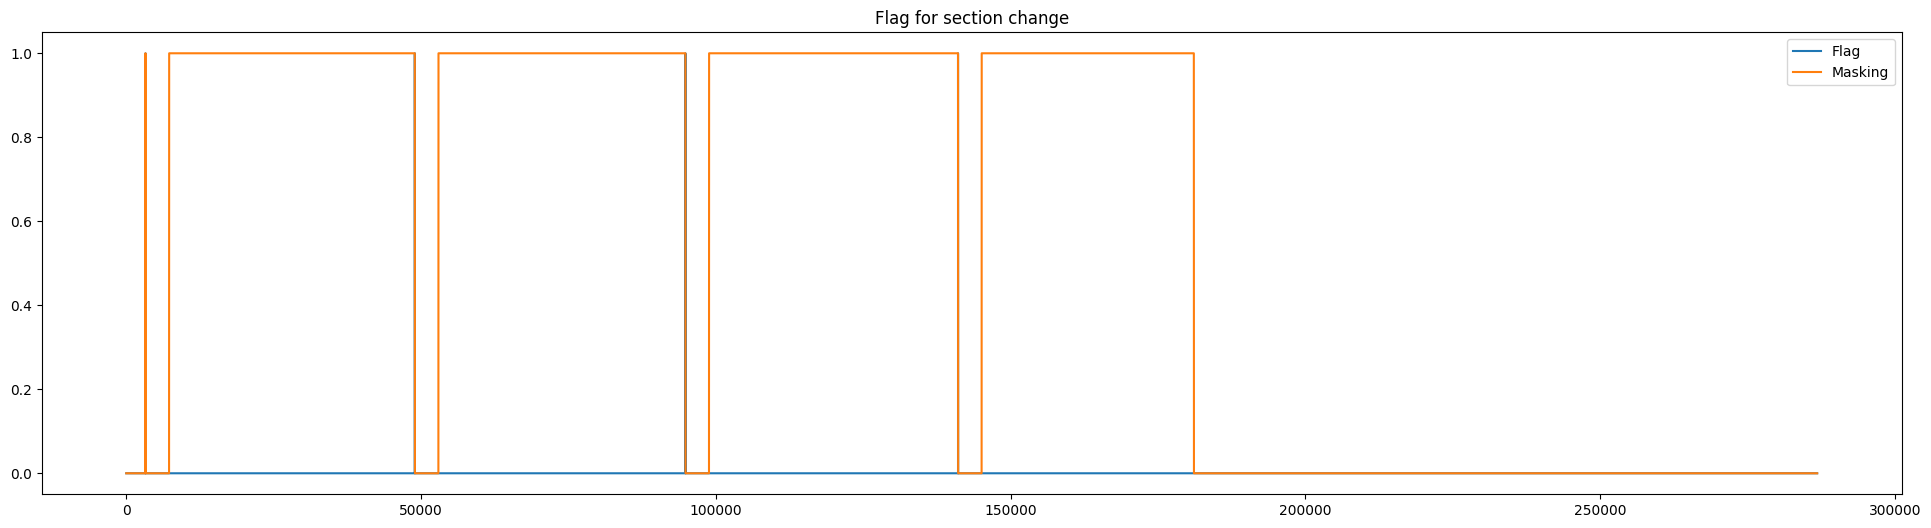

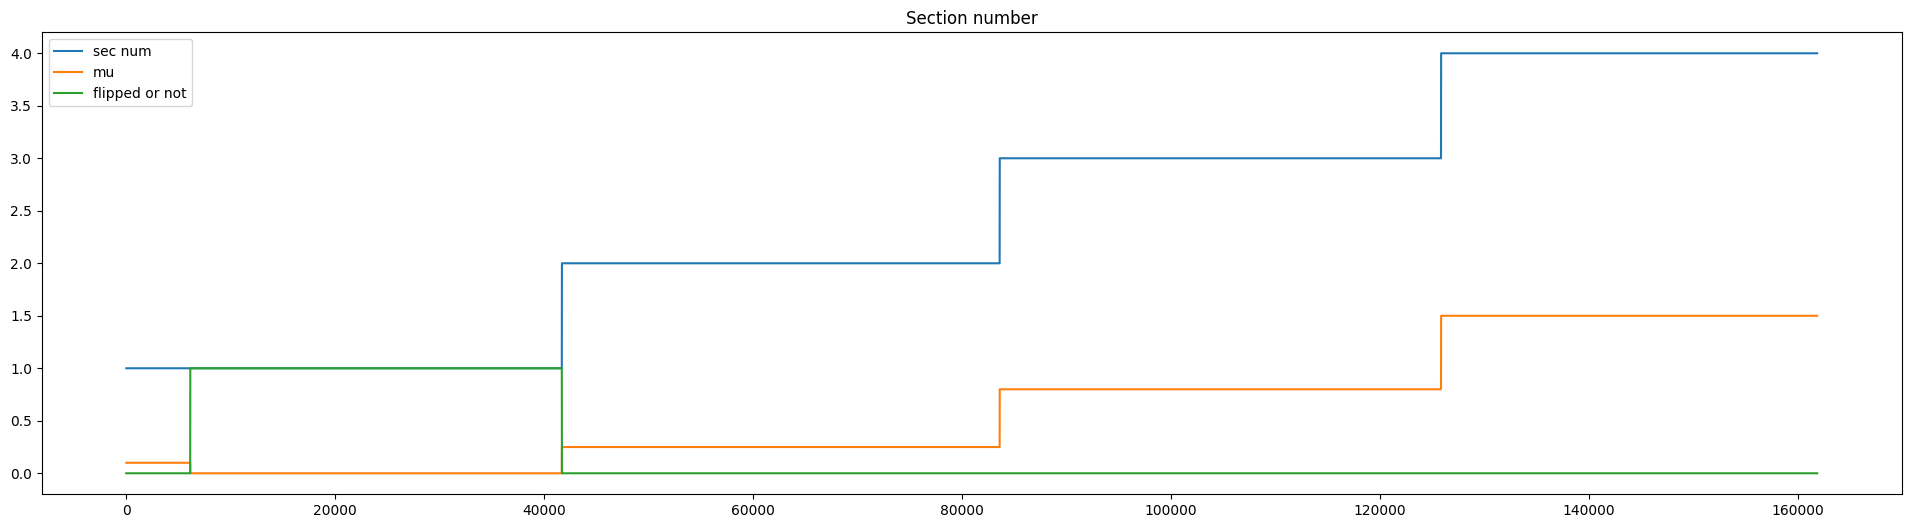

In [38]:
# Data Processing (Eliminate trash data) + Labelling

def CurrentSector(pos_glob, fric):  # Find the current sector number
    """
    pos_glob: current position of body link [X_global, Y_global] - dim = (timesteps, 2)
    return: the section number [1, 2, 3, 4] & mu
    """
    if pos_glob[0] > 0 :
        if pos_glob[1] > 0: # Section4, Black
            sec_num = 4
        else: # Section3, Green
            sec_num = 3
    else:
        if pos_glob[1] > 0: # Section2, Red
            sec_num = 2
        else: # Section1, Blue
            sec_num = 1
    mu = fric[ sec_num-1 ]
    return sec_num, mu



def SectionChange(pos_glob):  # Find the flag of Section Change
    """
    pos_glob: current position of body link [X_global, Y_global] - dim = (timesteps, 2)
    return: ndarray that has flag info along time-series

    If there's a abrupt change on global position, it's Section Change
    """
    sec_change = np.zeros( pos_glob.shape[0] )
    for i in range(1, pos_glob.shape[0]):
        x_diff = np.abs( pos_glob[i, 0] - pos_glob[i-1, 0] )
        y_diff = np.abs( pos_glob[i, 1] - pos_glob[i-1, 1] )
        if (x_diff > 10 or y_diff > 10):
            sec_change[i] = 1
    return sec_change


def Standardization(vel_body, Joint_pos, Joint_vel, ranges):
    # # Max-Min normalize (account for sampling range)
    # Joint_pos_norm = Joint_pos
    # for i in range(12):
    #     if i % 3 == 0:
    #         Joint_pos_norm[:, i] = (Joint_pos_norm[:, i] - ranges[0, 0]) / ( ranges[0, 1] - ranges[0, 0] )
    #     elif i % 3 == 1:
    #         Joint_pos_norm[:, i] = (Joint_pos_norm[:, i] - ranges[1, 0]) / ( ranges[1, 1] - ranges[1, 0] )
    #     elif i % 3 == 2:
    #         Joint_pos_norm[:, i] = (Joint_pos_norm[:, i] - ranges[2, 0]) / ( ranges[2, 1] - ranges[2, 0] )
    
    # Z-standardization
    vel_scaler = StandardScaler()
    joint_pos_scaler = StandardScaler()
    joint_vel_scaler = StandardScaler()

    vel_body_z = vel_scaler.fit_transform(vel_body)
    Joint_pos_z = joint_pos_scaler.fit_transform(Joint_pos)
    Joint_vel_z = joint_vel_scaler.fit_transform(Joint_vel)

    # # Z-standardization
    # mean_q = np.array( [0.13648255,  1.02416556, -1.95959108, -0.14131353,  1.04013948, -1.95004023,
    # 0.14954833,  1.06459323, -1.96615373, -0.1464817,   1.06452196, -1.96095472] )
    # std_q = np.array( [0.21421655,  0.32568444,  0.32402931,  0.1834761,   0.3377815,   0.32727451,
    # 0.10527512,  0.32064652,  0.33408471,  0.1218982,   0.32983543,  0.32722624] )
    # std_qd = np.array( [0.90501806,   1.79143876,   2.34617924,   0.89090604,
    # 1.77888479,   2.36617882,   0.85101701,   1.74792794,   2.39545959,
    # 0.84295406,   1.76532283,   2.40336001] )
    # std_vel_body = np.array( [  0.78711581,   1.42236275, 0.36703331] )

    # vel_body_z = vel_body
    # Joint_pos_z = Joint_pos
    # Joint_vel_z = Joint_vel
    
    # for i in range(3):
    #     vel_body_z[:, i] = vel_body_z[:, i] / std_vel_body[i]

    # for i in range(12):
    #     Joint_pos_z[:, i] = ( Joint_vel_z[:, i] - mean_q[i] ) / std_q[i]
    #     Joint_vel_z[:, i] = Joint_vel_z[:, i] / std_qd[i]

    return vel_body_z, Joint_pos_z, Joint_vel_z

def Normalization(dat, max_abs):
    N = dat.shape[1]
    norm = np.zeros_like( dat )
    for i in range(N):
        norm[:, i] = ( dat[:, i] / max_abs[i] )
    return norm

##########


pos_glob = q[:, 0:2]  # Global position information
# print(pos_glob.shape[0])
friction = np.array( [0.1, 0.25, 0.8, 1.5] )
flag = SectionChange(pos_glob)  # Flag for section change
num_scenes = np.sum( flag )   # Number of scenes ( trails that are indep. each other ) -- Check if it is 40
print(f"Total number of scenes: {num_scenes}")

mask = np.ones_like(pos_glob[:, 0], dtype=bool)  # masking array to eliminate trash data
stand_period = 4000  # The peroid that robot was standing after section has been changed ( 4 sec )

for i in range(len(flag)):
    if flag[i] == 1:
        mask[i+1 : i + stand_period] = False  # Set standing period to False
    elif i<=np.where(flag==1)[0][0] or i>=(np.where(flag==1)[0][-1]+40000):
        mask[i] = False  # Cut start and end period

plt.figure( figsize=(24, 6) )
plt.plot( flag )
plt.title("Flag for section change")
plt.plot(mask)
plt.legend(["Flag", "Masking"])


flag_masked = flag[mask]

# Data that only contains Walking data !
q_masked = q[mask]
mean_q = np.mean(q_masked, axis = 0)
std_q = np.std(q_masked, axis = 0)
# print("Mean of q: ")
# print(mean_q)
# print("Std of q: ")
# print(std_q)

qd_masked = qd[mask]
mean_qd = np.mean(qd_masked, axis = 0)
std_qd = np.std(qd_masked, axis = 0)
# print("Mean of qd: ")
# print(mean_qd)
# print("Std of qd: ")
# print(std_qd)

ctrl_args_masked = arguments[mask]

N_t_masked = q_masked.shape[0]
print(f"Number of timesteps in masked data: {N_t_masked}")

R_gb = np.zeros( (N_t_masked, 3, 3) )
R_gb = R.from_euler('xyz', q_masked[:, 3:6]).as_matrix()
print(f"Shape of Rot Mtx arr: {R_gb.shape}")

vel_body = np.zeros( (N_t_masked, 6) )
vel_body_processed = np.zeros( (N_t_masked, 3) )
for i in range( N_t_masked ):
    vel_body[i, 0:3] = R_gb[i, :, :].T @ qd_masked[i, 0:3]   # Linear velocity
    vel_body[i, 3:6] = R_gb[i, :, :].T @ qd_masked[i, 3:6]   # Angular velocity
mean_v_body = np.mean(vel_body, axis=0)
std_v_body = np.std(vel_body, axis=0)
# print("Mean of vel_body: ")
# print(mean_v_body)
# print("Std of vel_body: ")
# print(std_v_body)

### 
vel_body_processed = vel_body[:, [0, 1, 5]]   # [ Vx_measured, Vy_measured, Vrz_measured ] in body frame
Joint_pos_processed = q_masked[:, 6:18]
Joint_vel_processed = qd_masked[:, 6:18]

# Normalize each data !
ranges = np.array( [[-1.0472, 1.0472], # Q_**1
                    [-1.5708, 3.4907], # Q_**2
                    [-2.7227, -0.83776], # Q_**3
                    ] )
vel_body_processed, Joint_pos_processed, Joint_vel_processed = Standardization(vel_body_processed, Joint_pos_processed, Joint_vel_processed, ranges)


# Calculate statistical values

# max_v_b = np.abs( np.max( vel_body_processed, axis=0 ) )
# min_v_b = np.abs( np.min( vel_body_processed, axis=0 ) )
# max_abs_v_b = np.zeros( 3 )
# for i in range(3):
#     max_abs_v_b[i] = max( max_v_b[i], min_v_b[i] )
# print("max_abs_v_b")
# print(max_abs_v_b)
# vel_body_processed = Normalization( vel_body_processed, max_abs_v_b )

# max_J_pos = np.abs( np.max( Joint_pos_processed, axis=0 ) )
# min_J_pos = np.abs( np.min( Joint_pos_processed, axis=0 ) )
# max_abs_J_pos = np.zeros( 12 )
# for i in range(12):
#     max_abs_J_pos[i] = max( max_J_pos[i], min_J_pos[i] )
# print("max_abs_J_pos")
# print(max_abs_J_pos)
# Joint_pos_processed = Normalization( Joint_pos_processed, max_abs_J_pos )

# max_J_vel = np.abs( np.max( Joint_vel_processed, axis=0 ) )
# min_J_vel = np.abs( np.min( Joint_vel_processed, axis=0 ) )
# max_abs_J_vel = np.zeros( 12 )
# for i in range(12):
#     max_abs_J_vel[i] = max( max_J_vel[i], min_J_vel[i] )
# print("max_abs_J_vel")
# print(max_abs_J_vel)
# Joint_vel_processed = Normalization( Joint_vel_processed, max_abs_J_vel )

# Plot variables

# plt.figure( figsize=(24, 6) )
# plt.plot(vel_body_processed[:, 0])
# plt.title("Vx_body")
# plt.figure( figsize=(24, 6) )
# plt.plot(vel_body_processed[:, 1])
# plt.title("Vy_body")
# plt.figure( figsize=(24, 6) )
# plt.plot(vel_body_processed[:, 2])
# plt.title("Vrz_body")

# plt.figure( figsize=(24, 6) )
# plt.plot(Joint_pos_processed[:])
# plt.legend(["Q_FL1", "Q_FL2", "Q_FL3", "Q_FR1", "Q_FR2", "Q_FR3", "Q_RL1", "Q_RL2", "Q_RL3", "Q_RR1", "Q_RR2", "Q_RR3"])
# plt.title("Joint Pos")

# plt.figure( figsize=(24, 6) )
# plt.plot(Joint_vel_processed[:])
# plt.legend(["Q_FL1", "Q_FL2", "Q_FL3", "Q_FR1", "Q_FR2", "Q_FR3", "Q_RL1", "Q_RL2", "Q_RL3", "Q_RR1", "Q_RR2", "Q_RR3"])
# plt.title("Joint Vel")


section = np.zeros( N_t_masked )   # Store Current Section number

###  Find flip status
mu_flipped = 0  # Define the mu value when it is flipped
flip_flag = np.zeros(N_t_masked, dtype=bool)
for i in range(N_t_masked):
    if R_gb[i, 2, 2] < 0:   # When z-axis of body frame directs downward
        flip_flag[i] = 1
###

mu = np.zeros( N_t_masked )   # Store Current Section's firction coeffcient

for i in range( N_t_masked ):
    section[i], mu[i] = CurrentSector( q_masked[i, 0:2], friction )
    if flip_flag[i] == 1:
        mu[i] = mu_flipped

plt.figure( figsize=(24, 6) )
plt.plot(section)
plt.plot(mu)
plt.plot(flip_flag)
plt.title("Section number")
plt.legend(["sec num", "mu", "flipped or not"])



# Now, let's split the data into each scene based on the flag
Processed_dataset = []

start_idx = np.where(flag==1)[0][0] + stand_period # first index which flag = 1 + standing period
# Loop through the flag array and separate the data into different scenes
for i in range( start_idx+1, len(flag_masked) ):
    if flag_masked[i] == 1:  # New scene starts
        end_idx = i - 1
        # Extract scene data
        scene_BodyRoll = q_masked[start_idx:end_idx, 3]  # dim. = 1
        scene_BodyRoll = scene_BodyRoll[:, np.newaxis]
        scene_ctrl_args = ctrl_args_masked[start_idx:end_idx, 1:4]  # dim. = 3
        scene_BodyVel = vel_body_processed[start_idx:end_idx]  # dim. = 3
        scene_JointPos = Joint_pos_processed[start_idx:end_idx]  # dim. = 12
        scene_JointVel = Joint_vel_processed[start_idx:end_idx]  # dim. = 12
        scene_mu = mu[start_idx:end_idx]  # Extract mu values corresponding to the scene
        # Combine scene data with friction coefficient (mu)
        # Create an array of shape ( timesteps, (dim. of variables + 1) )
        scene_combined = np.hstack([scene_BodyRoll, scene_ctrl_args, scene_BodyVel, scene_JointPos, scene_JointVel, scene_mu[:, np.newaxis]])
        # print( scene_combined.shape )
        Processed_dataset.append(scene_combined)  # Append to the scenes list
        start_idx = i + stand_period # Update the start index for the next scene

# Add the last scene (after the last flag change)
scene_BodyRoll = q_masked[start_idx:, 3]  # dim. = 1
scene_BodyRoll = scene_BodyRoll[:, np.newaxis]
scene_ctrl_args = ctrl_args_masked[start_idx:, 1:4]  # dim. = 3
scene_BodyVel = vel_body_processed[start_idx:]
scene_JointPos = Joint_pos_processed[start_idx:]
scene_JointVel = Joint_vel_processed[start_idx:]
scene_mu = mu[start_idx:]
scene_combined = np.hstack([scene_BodyRoll, scene_ctrl_args, scene_BodyVel, scene_JointPos, scene_JointVel, scene_mu[:, np.newaxis]])
Processed_dataset.append(scene_combined)  # ( # of scenes, timesteps, trajectory variable dimensions, current variable dimensions )'

print( Processed_dataset[0].shape )

### Export to local File

In [ ]:
# #### Save data list as .pkl file (for fast loading)

# print( Processed_dataset[0].shape )

# Save to pickle file
# with open("Train2_20250326_154150_go2.pkl", "wb") as f:
#     pickle.dump(Processed_dataset, f)